In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, matthews_corrcoef
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import catboost as cb
import warnings

warnings.filterwarnings('ignore')

# 1. Loading the Dataset

In [3]:
data = pd.read_csv("Final_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Person             978 non-null    object 
 1   Wav file           978 non-null    object 
 2   MDVP:Fo(Hz)        978 non-null    float64
 3   MDVP:Fhi(Hz)       978 non-null    float64
 4   MDVP:Flo(Hz)       978 non-null    float64
 5   MDVP:Jitter(%)     978 non-null    float64
 6   MDVP:Jitter(Abs)   978 non-null    float64
 7   MDVP:RAP           978 non-null    float64
 8   MDVP:PPQ           978 non-null    float64
 9   Jitter:DDP         978 non-null    float64
 10  MDVP:Shimmer       978 non-null    float64
 11  MDVP:Shimmer (dB)  978 non-null    float64
 12  Shimmer:APQ3       978 non-null    float64
 13  Shimmer:APQ5       978 non-null    float64
 14  MDVP:APQ           978 non-null    float64
 15  Shimmer:DDA        978 non-null    float64
 16  NHR                978 non

# 2. Preprocessing


In [4]:
# Check for duplicate entries
data.drop_duplicates(inplace=True)

In [5]:
# Missing values handling for numeric columns only
numeric_data = data.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# Replace the original numeric columns with the imputed ones
data[numeric_data.columns] = data_imputed

In [6]:
english_data = data[data['language'] == 'English']
Italian_data = data[data['language'] == 'Italian']
merged_data = pd.concat([english_data, Italian_data])

In [7]:
# Remove unwanted columns
english_data.drop(columns=['Person', 'language', 'Wav file'], inplace=True)
Italian_data.drop(columns=['Person', 'language', 'Wav file'], inplace=True)
merged_data.drop(columns=['Person', 'language', 'Wav file'], inplace=True)



Outliers for English Data with parkinson:


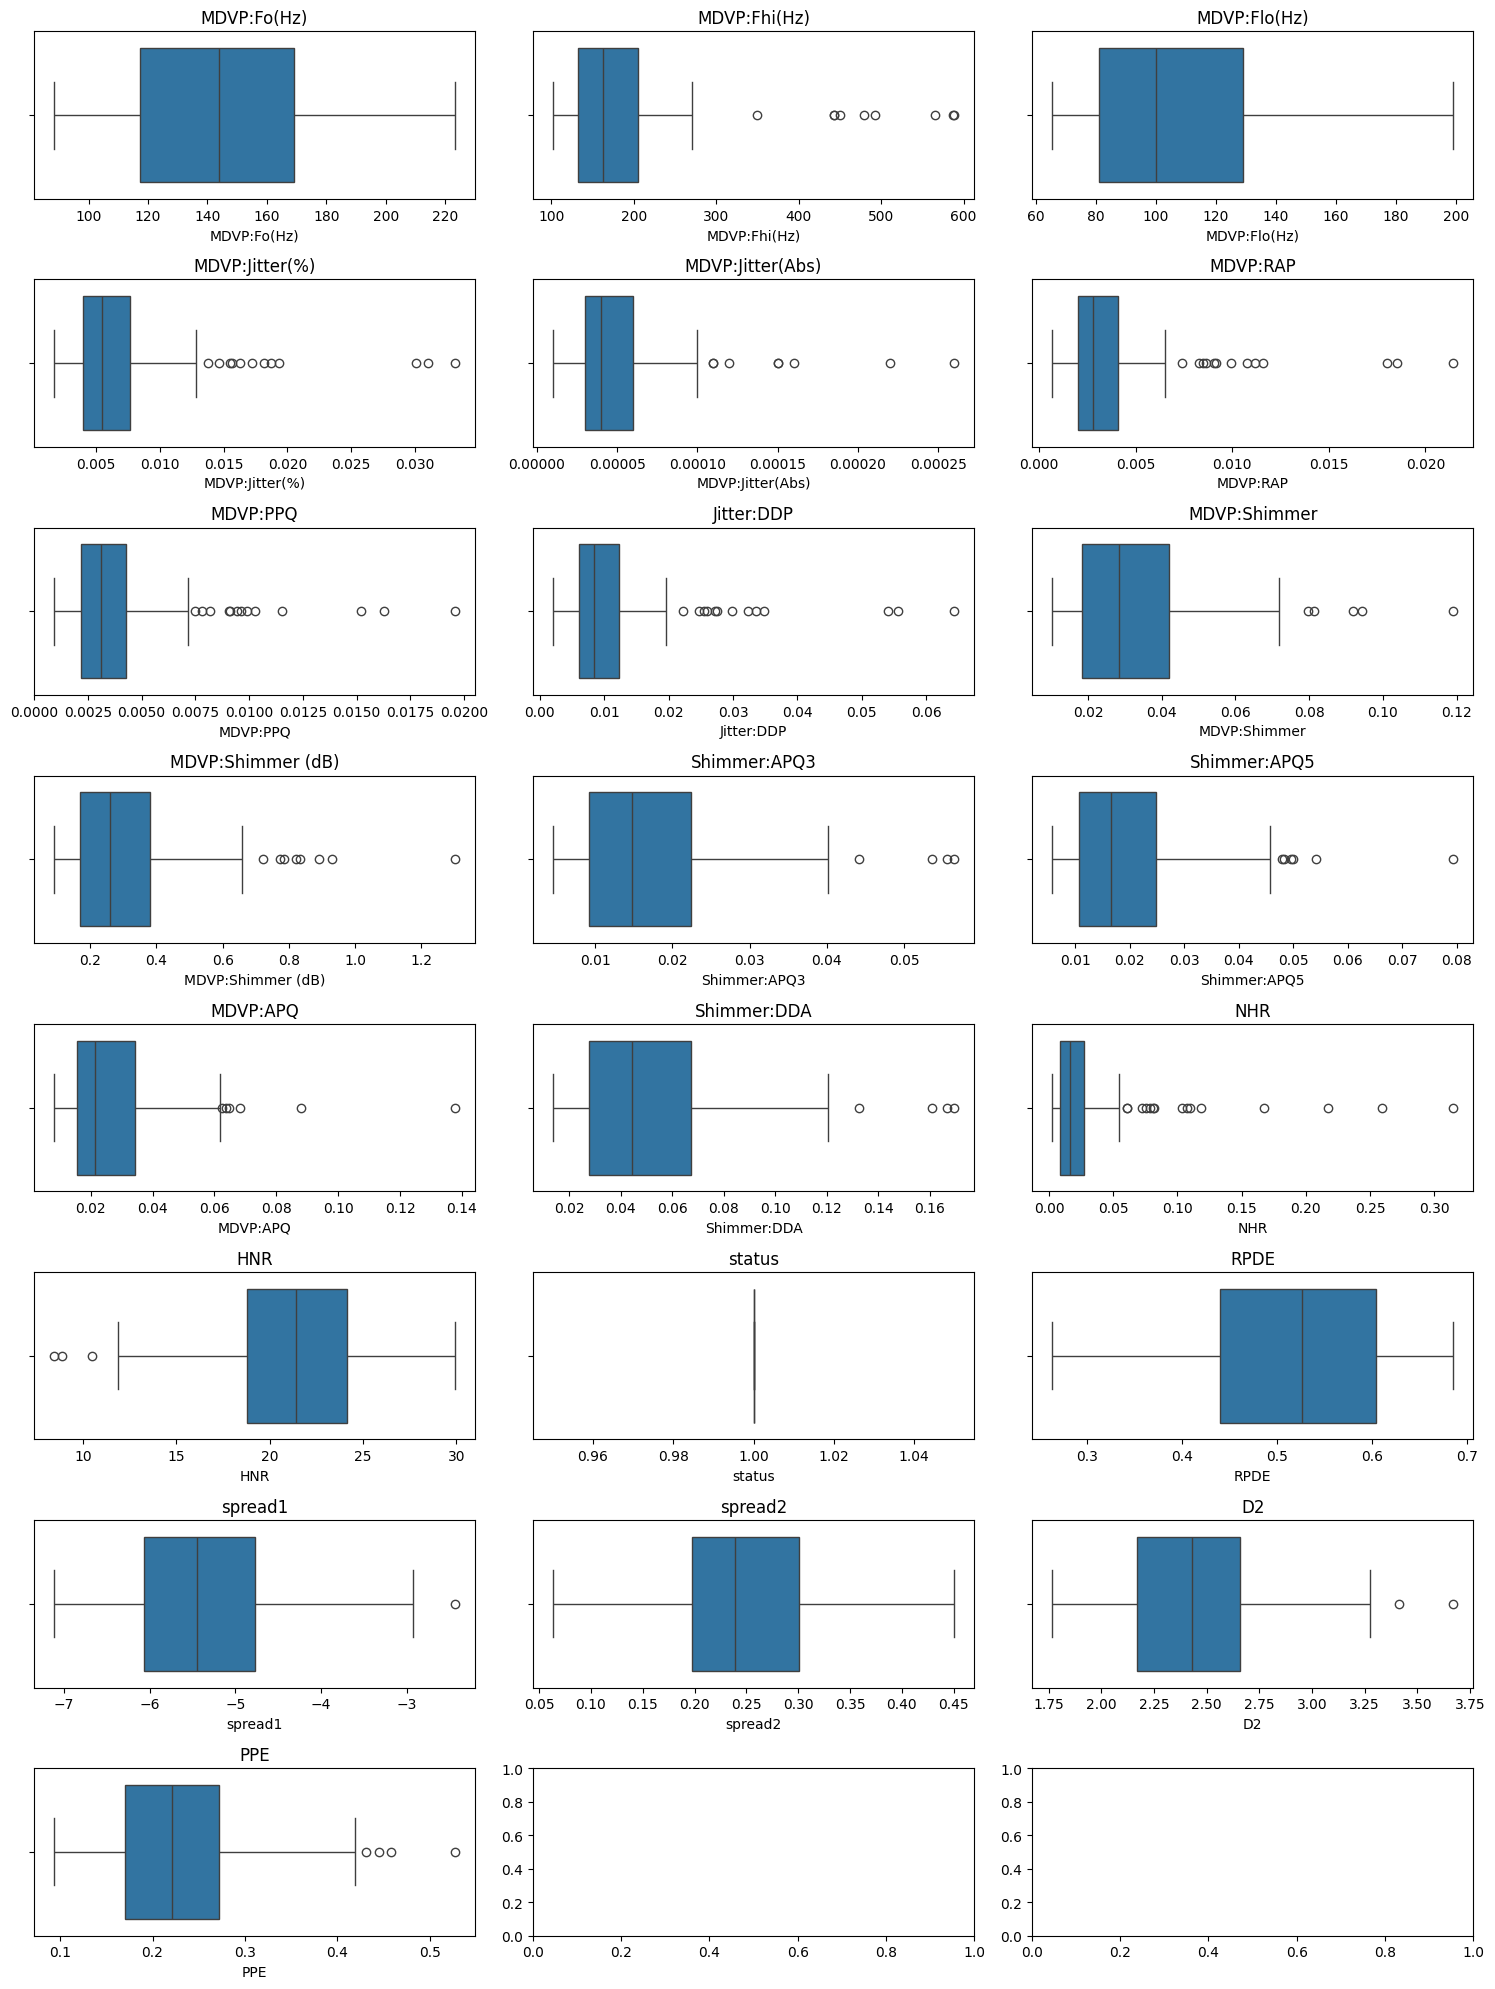



Outliers for English Data without parkinson:


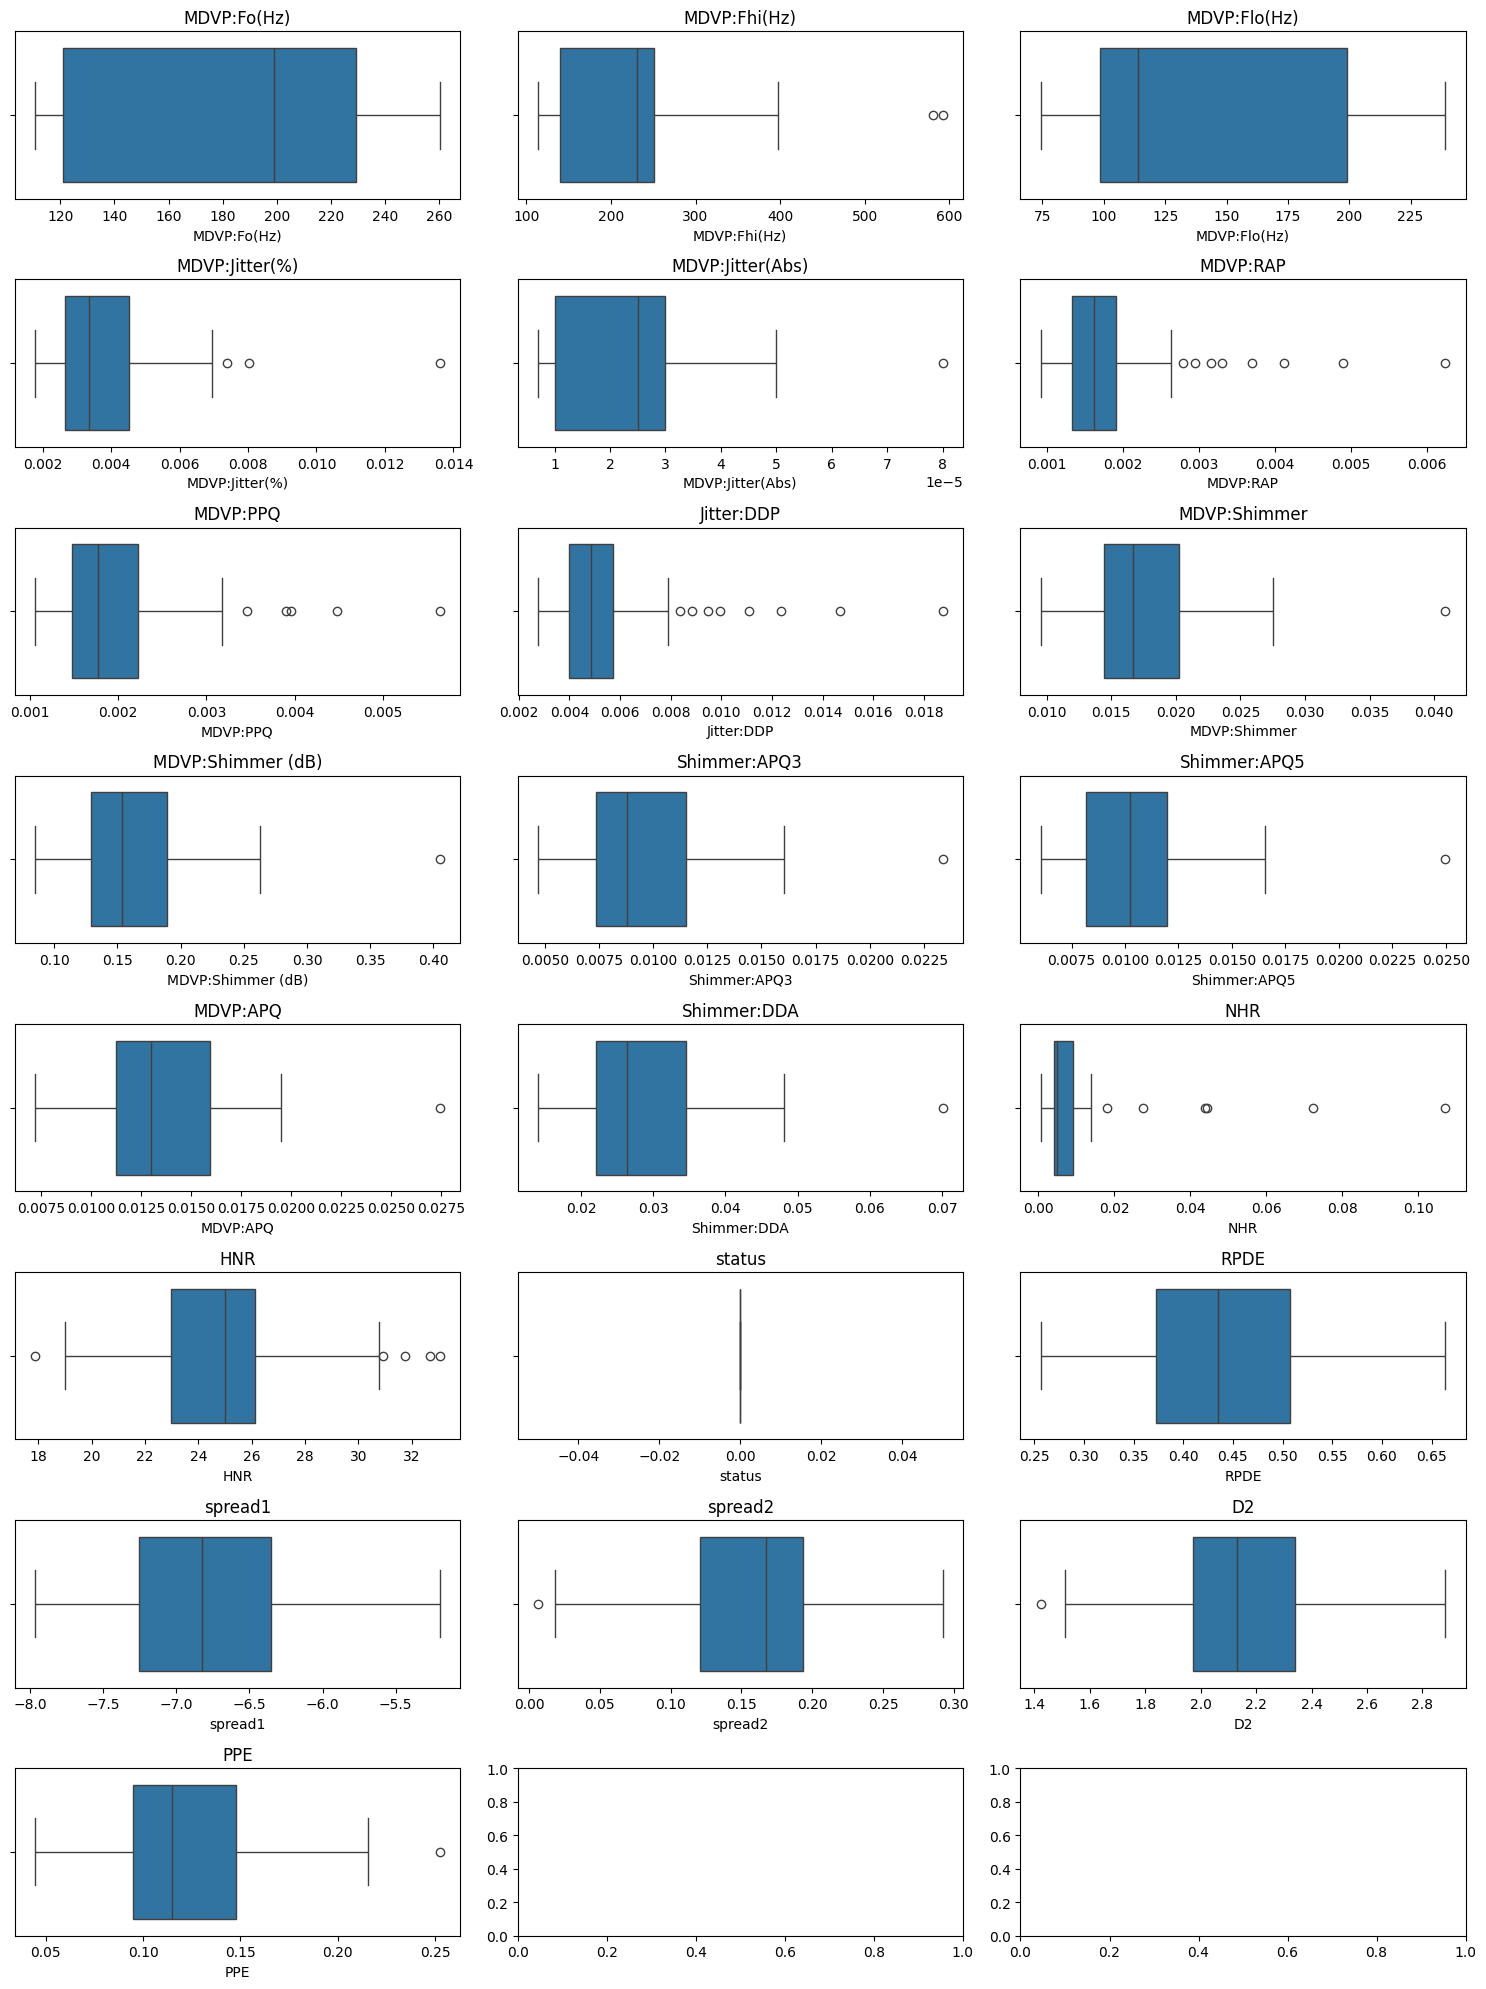



Outliers for Italian Data with parkinson:


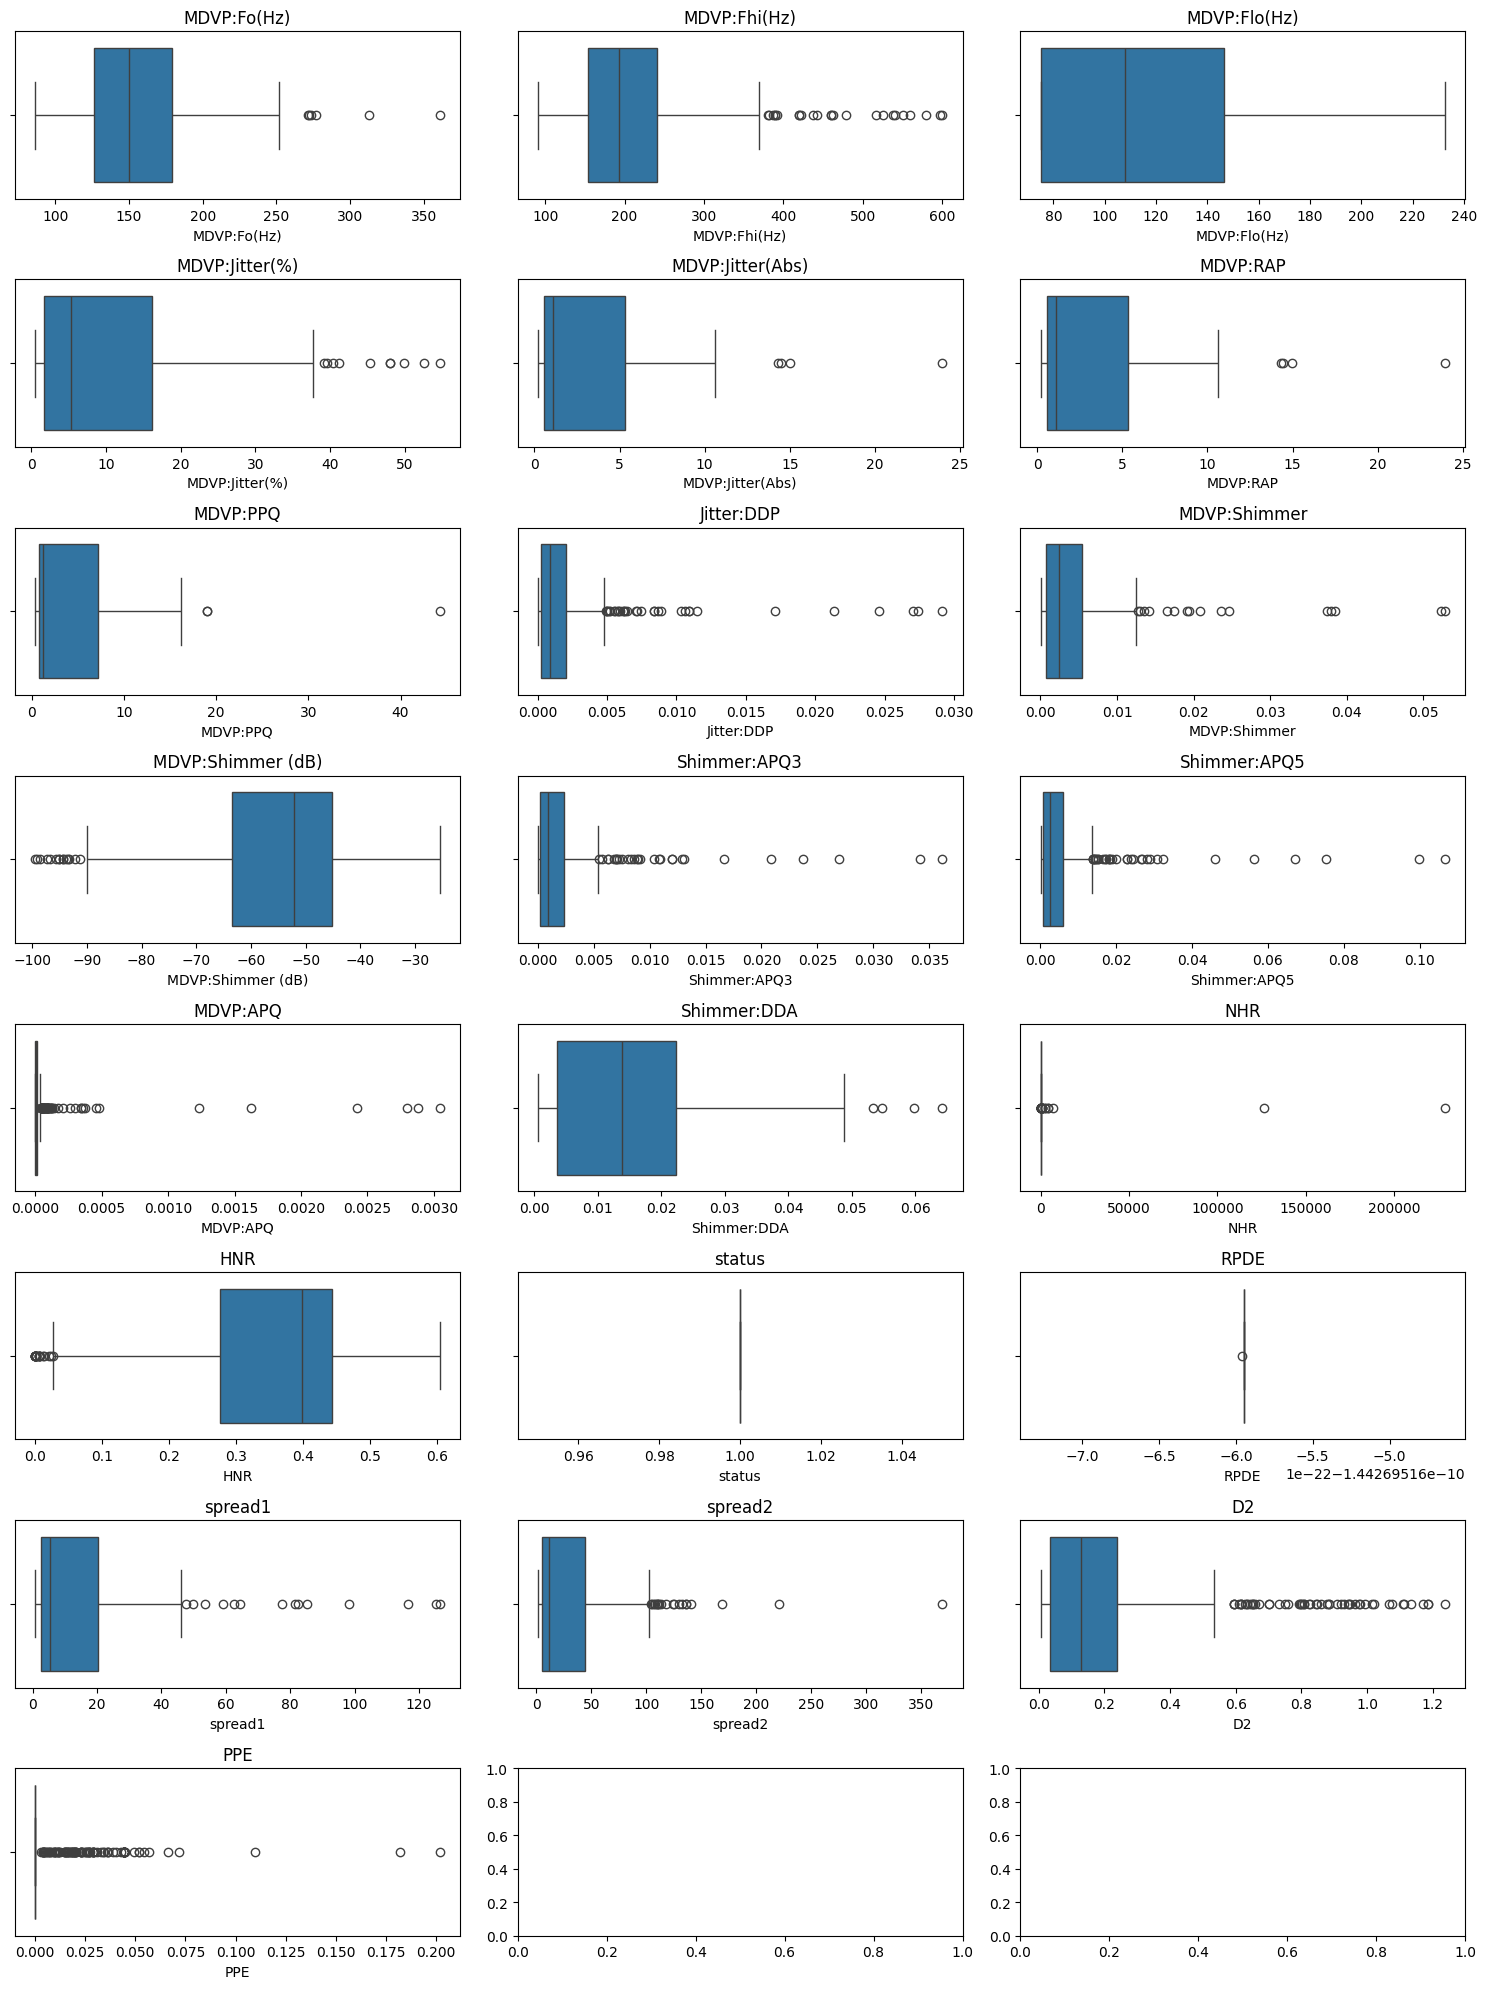



Outliers for Italian Data without parkinson:


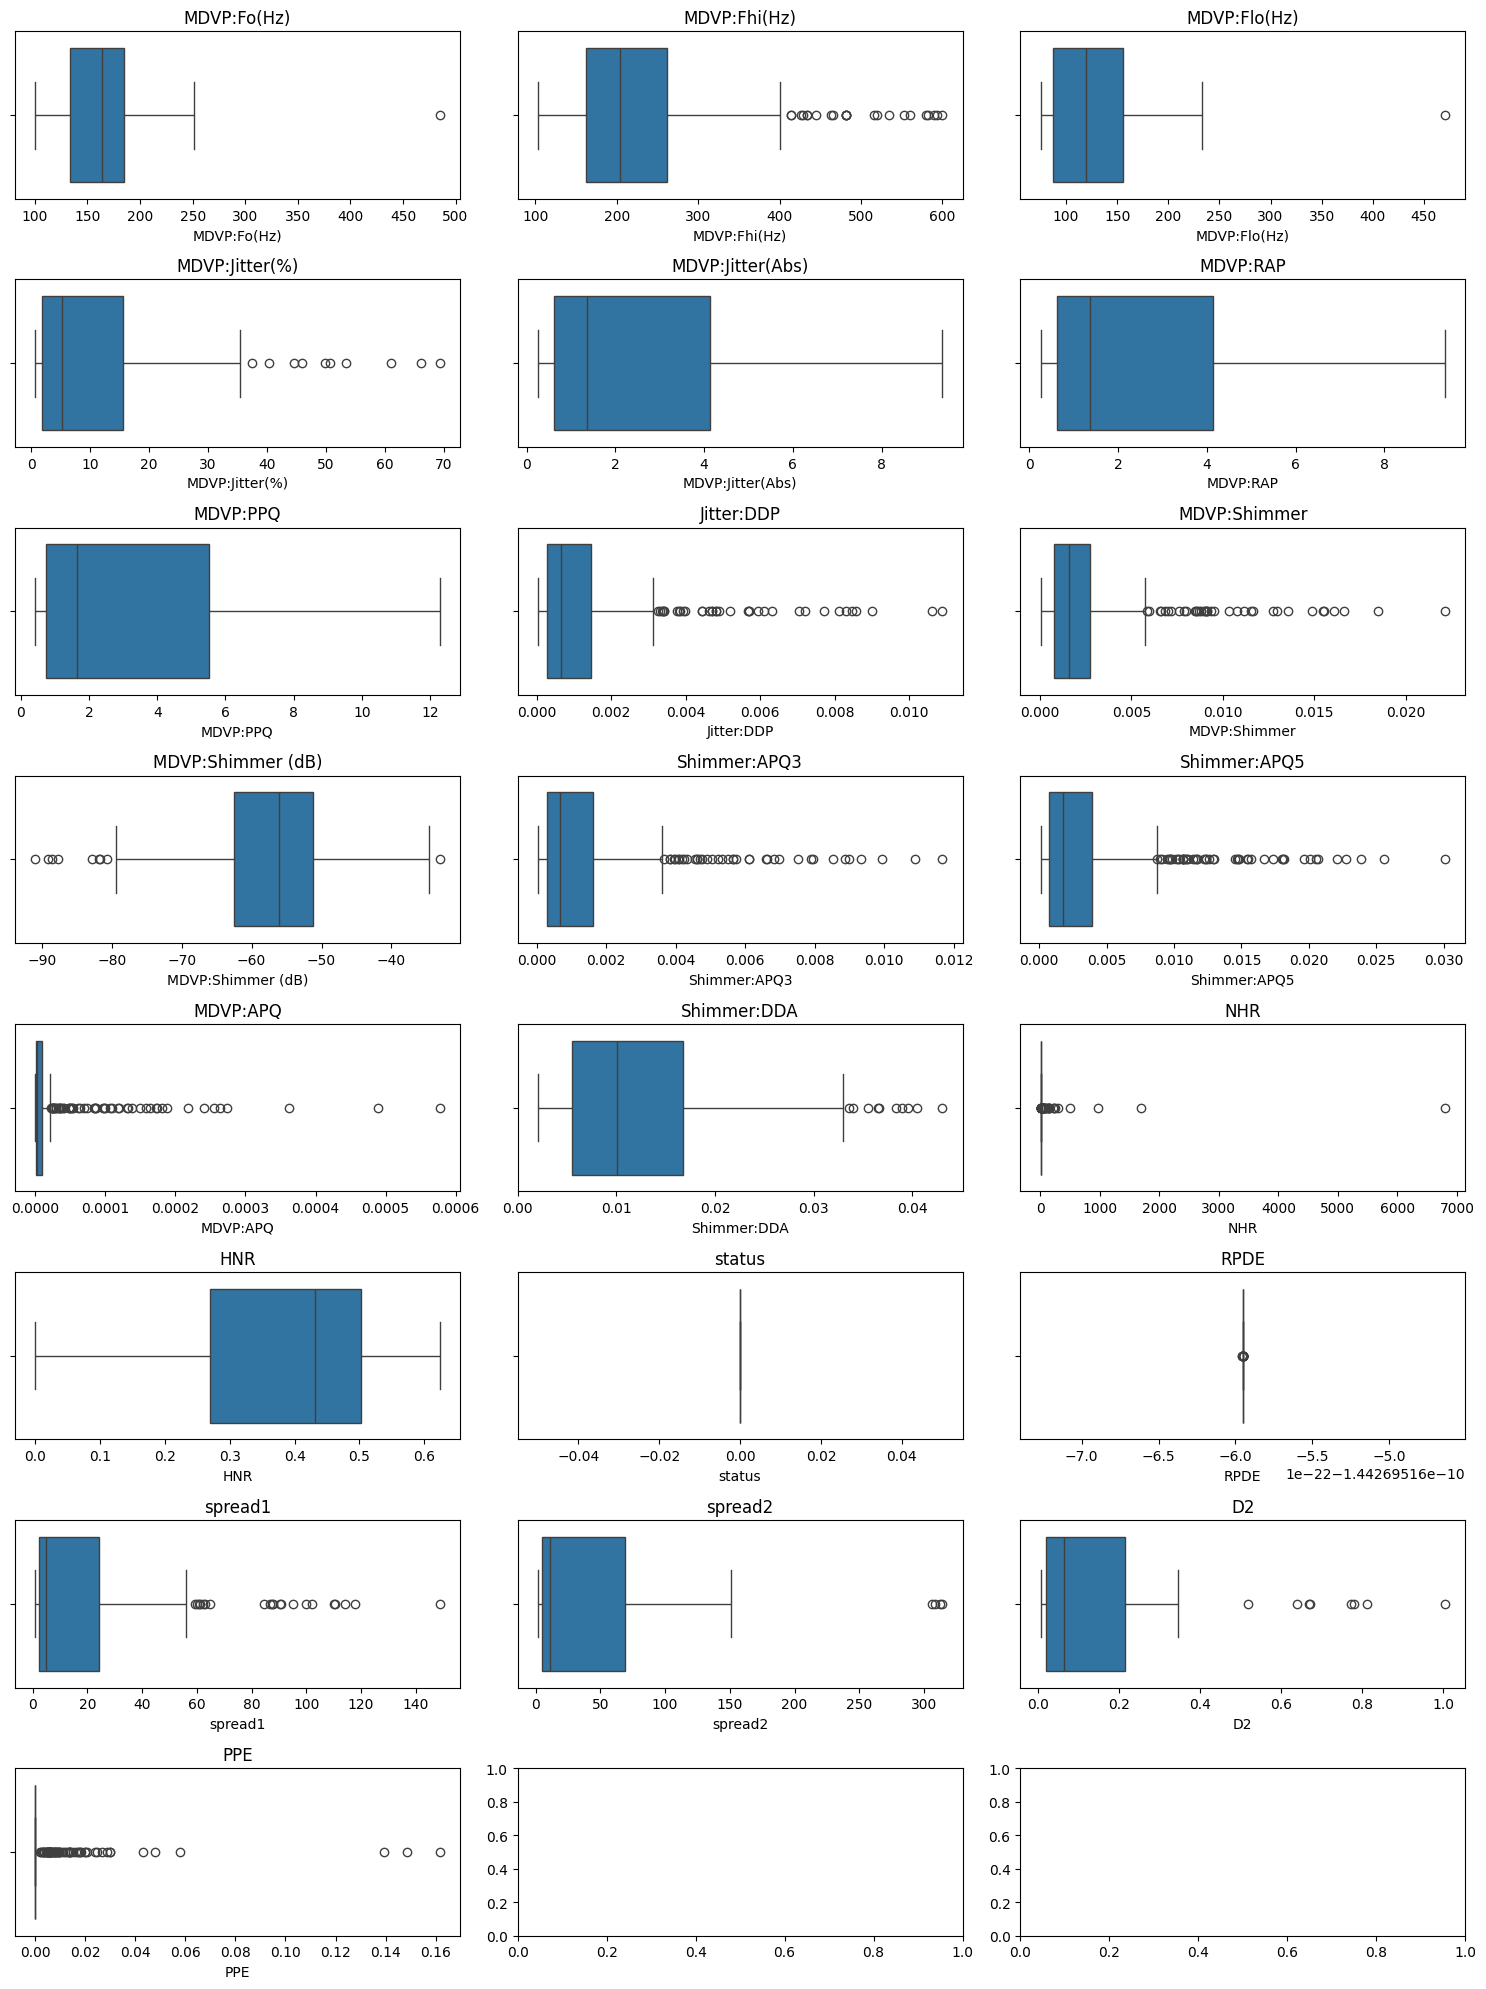



Outliers for Merged Data with parkinson:


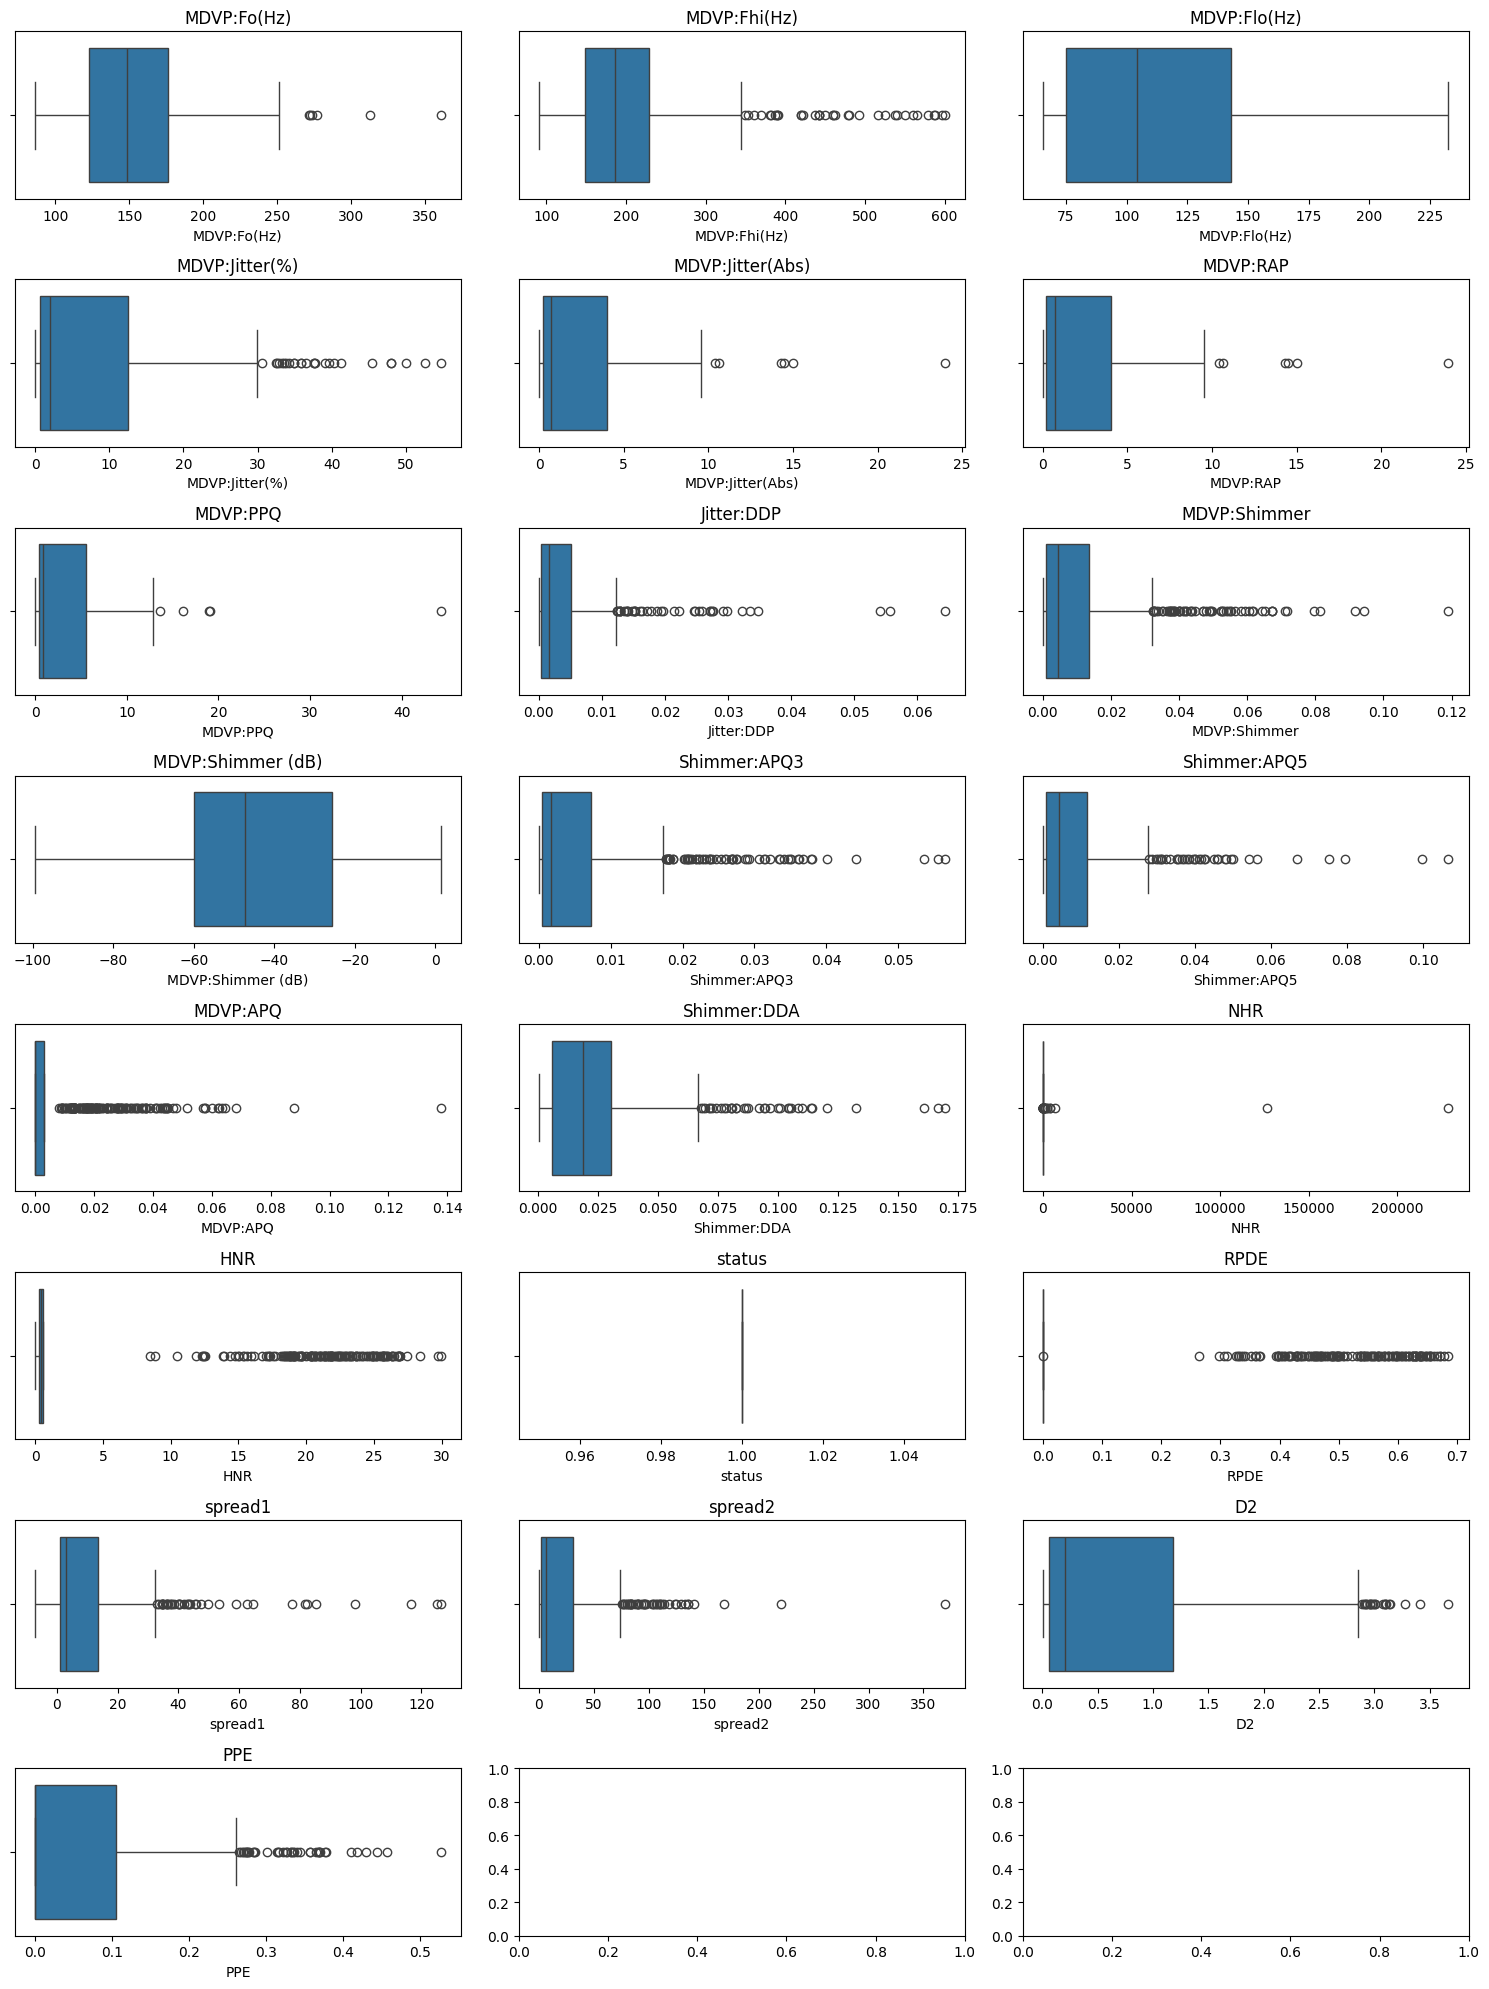



Outliers for Merged Data without parkinson:


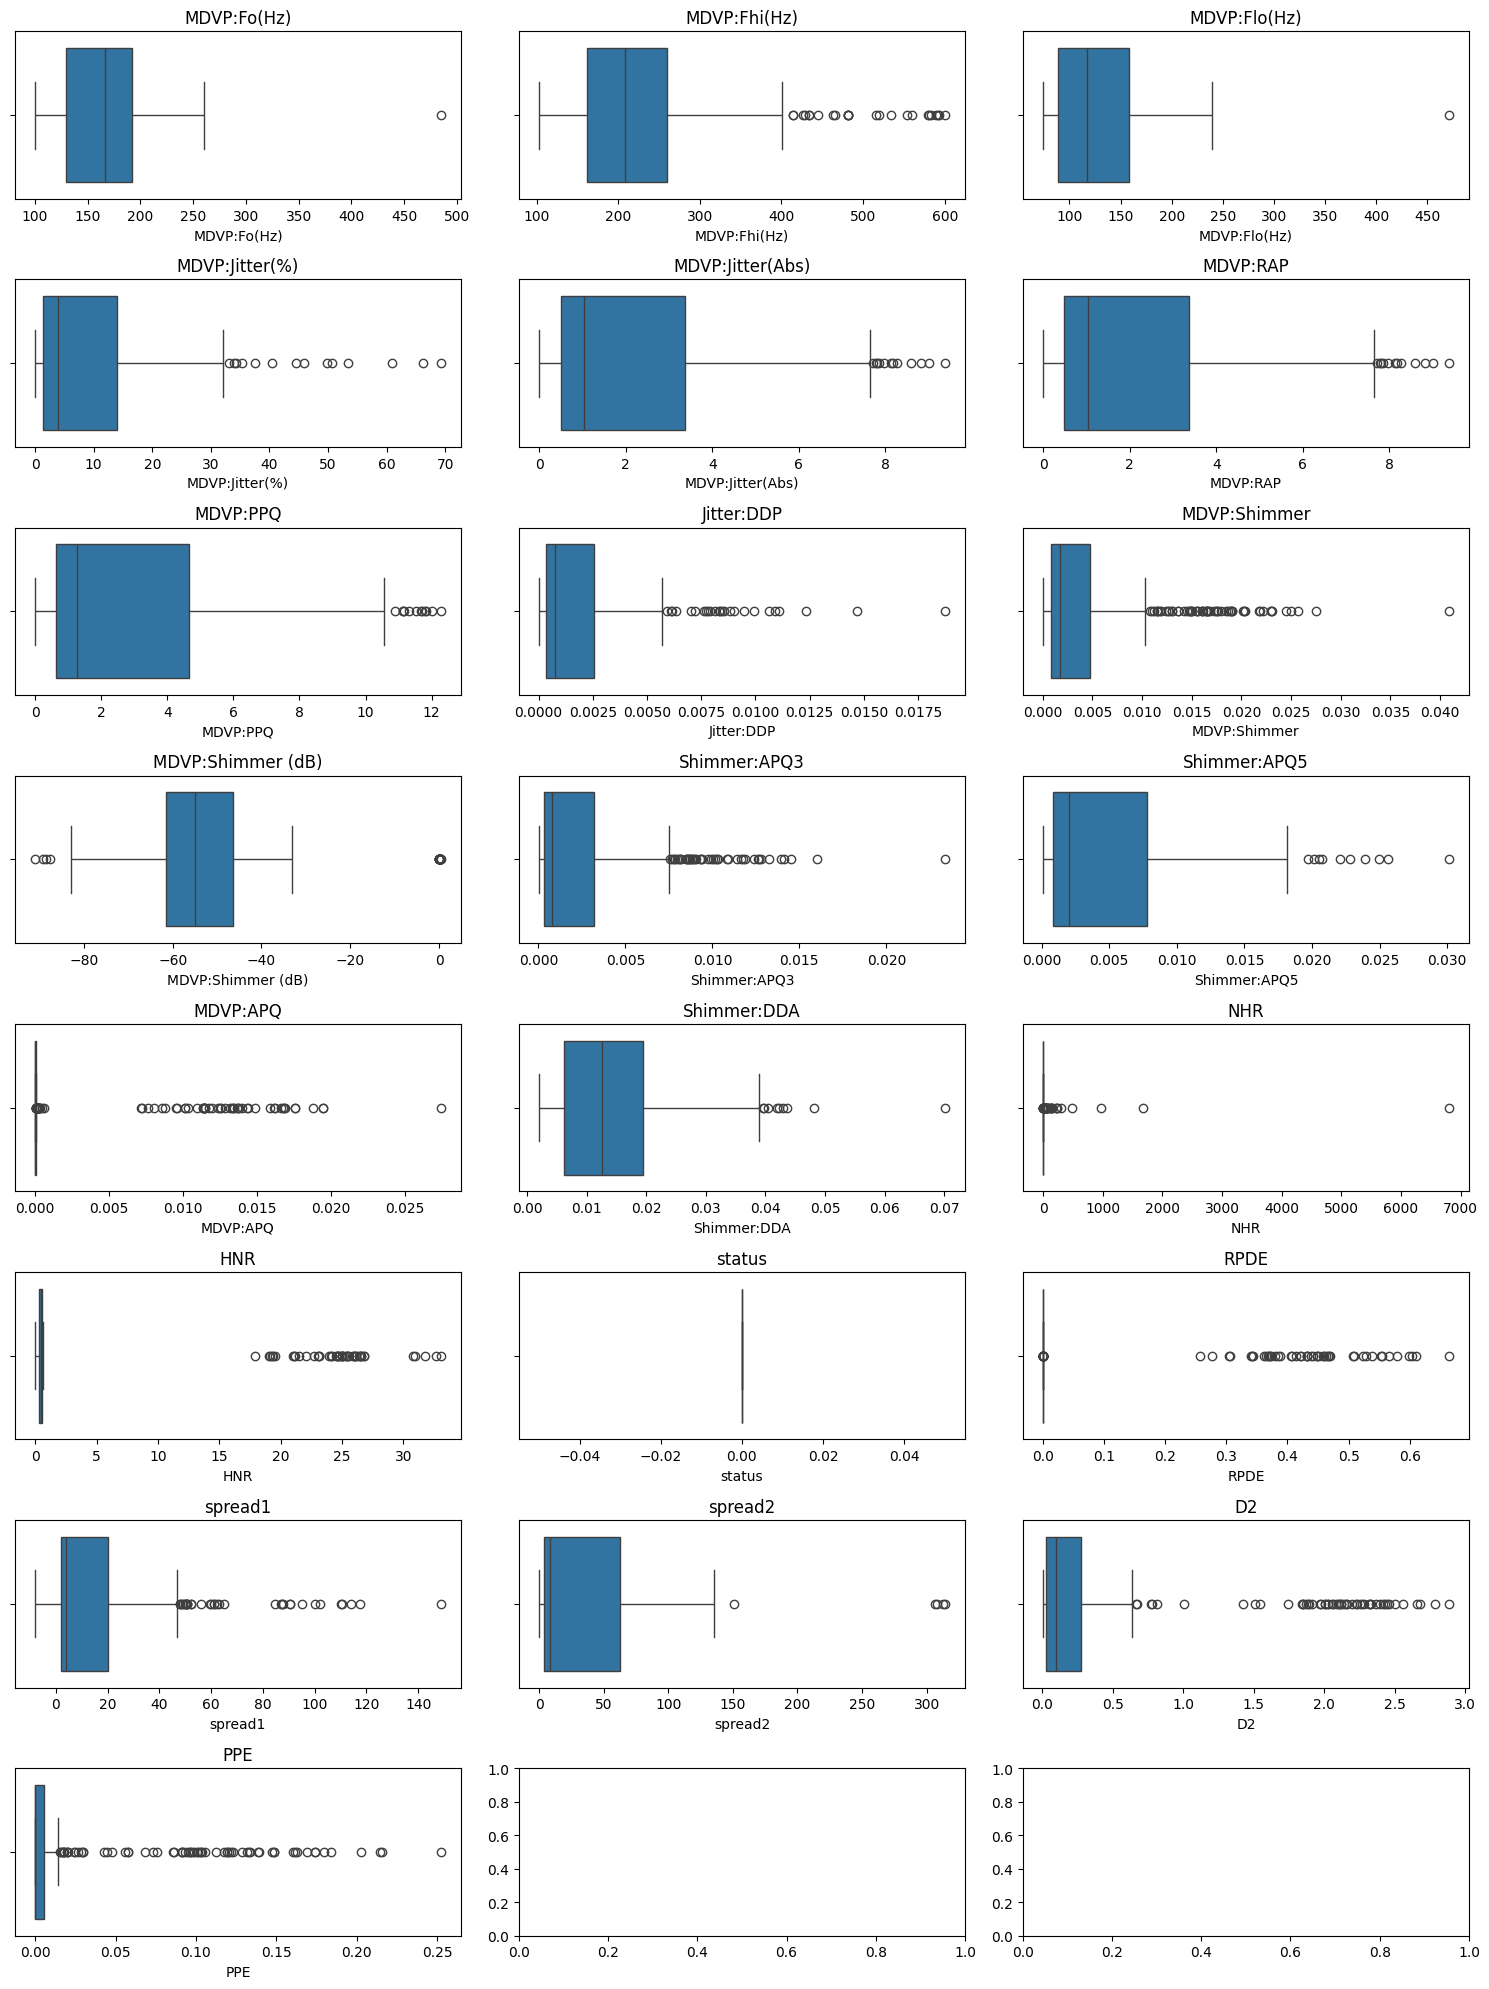

In [8]:
# Check for outliers

def detect_outliers(df_name, data):
    
    print(f"\n\nOutliers for {df_name}:")
    # Count the number of numerical columns
    num_cols = len([col for col in data.columns if data[col].dtype != 'object'])

    # Set up subplots for box plots
    fig, axs = plt.subplots(nrows=(num_cols + 2) // 3, ncols=3, figsize=(15, 20))

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    # Loop through each numerical feature and plot box plot
    for i, column in enumerate(data.columns):
        if data[column].dtype != 'object':  # Check if the column is numerical
            sns.boxplot(x=data[column], ax=axs[i], orient='h')
            axs[i].set_title(f'{column}')

    plt.tight_layout()
    plt.show()

detect_outliers("English Data with parkinson",english_data[english_data['status'] == 1])
detect_outliers("English Data without parkinson",english_data[english_data['status'] == 0])
detect_outliers("Italian Data with parkinson",Italian_data[Italian_data['status'] == 1])
detect_outliers("Italian Data without parkinson",Italian_data[Italian_data['status'] == 0])
detect_outliers("Merged Data with parkinson",merged_data[merged_data['status'] == 1])
detect_outliers("Merged Data without parkinson",merged_data[merged_data['status'] == 0])

In [9]:
# # english_data and Italian_data have outliers in some columns. We will remove them.
# Q1 = english_data.quantile(0.25)
# Q3 = english_data.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# e_outliers = ((english_data < lower_bound) | (english_data > upper_bound)).any(axis=1)
# print("Indices of outliers:")
# print(e_outliers[e_outliers].index)
# english_data = english_data[~e_outliers]


# Q1 = Italian_data.quantile(0.25)
# Q3 = Italian_data.quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# I_outliers = ((Italian_data < lower_bound) | (Italian_data > upper_bound)).any(axis=1)
# print("Indices of outliers:")
# print(I_outliers[I_outliers].index)
# Italian_data = Italian_data[~I_outliers]



In [10]:
# drop columns
english_data.drop(columns=['PPE','NHR','RPDE'])
Italian_data.drop(columns=['PPE','NHR','RPDE'])
merged_data.drop(columns=['PPE','NHR','RPDE'])

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer (dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,HNR,status,spread1,spread2,D2
0,119.992000,157.302000,74.997000,0.007840,0.000070,0.003700,0.005540,0.011090,0.043740,0.426000,0.021820,0.031300,0.029710,0.065450,21.033000,1.0,-4.813031,0.266482,2.301442
1,122.400000,148.650000,113.819000,0.009680,0.000080,0.004650,0.006960,0.013940,0.061340,0.626000,0.031340,0.045180,0.043680,0.094030,19.085000,1.0,-4.075192,0.335590,2.486855
2,116.682000,131.111000,111.555000,0.010500,0.000090,0.005440,0.007810,0.016330,0.052330,0.482000,0.027570,0.038580,0.035900,0.082700,20.651000,1.0,-4.443179,0.311173,2.342259
3,116.676000,137.871000,111.366000,0.009970,0.000090,0.005020,0.006980,0.015050,0.054920,0.517000,0.029240,0.040050,0.037720,0.087710,20.644000,1.0,-4.117501,0.334147,2.405554
4,116.014000,141.781000,110.655000,0.012840,0.000110,0.006550,0.009080,0.019660,0.064250,0.584000,0.034900,0.048250,0.044650,0.104700,19.649000,1.0,-3.747787,0.234513,2.332180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,109.480629,169.344661,75.000000,18.529456,4.851695,4.851695,6.338581,0.000459,0.001966,-54.128938,0.000437,0.000994,0.000002,0.004924,0.276722,1.0,20.681959,45.920800,0.238455
974,117.583634,124.685684,104.243866,1.874697,0.387523,0.387523,0.500678,0.002283,0.005436,-45.294518,0.002072,0.004220,0.000014,0.021001,0.396095,1.0,1.328195,2.862934,0.032206
975,117.149051,120.438432,114.999626,0.984730,0.356262,0.356262,0.542042,0.002757,0.006986,-43.114982,0.002510,0.005021,0.000020,0.026160,0.419438,1.0,1.532805,2.832705,0.919261
976,115.155070,132.099881,107.920019,1.632779,0.411457,0.411457,0.491512,0.000582,0.003310,-49.604573,0.000500,0.001424,0.000003,0.019963,0.500588,1.0,1.385324,2.844660,0.045541


In [11]:
english_data.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer (dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)

Italian_data.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer (dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)

merged_data.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer (dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)

In [12]:
#features and target variable

# Dependent variable
y_english = english_data['status']
y_italian = Italian_data['status']
y_merged = merged_data['status']

# Independent variables
X_english = english_data.drop(columns=['status'])
X_italian = Italian_data.drop(columns=['status'])
X_merged = merged_data.drop(columns=['status'])


 Correlation Matrix for English Data:


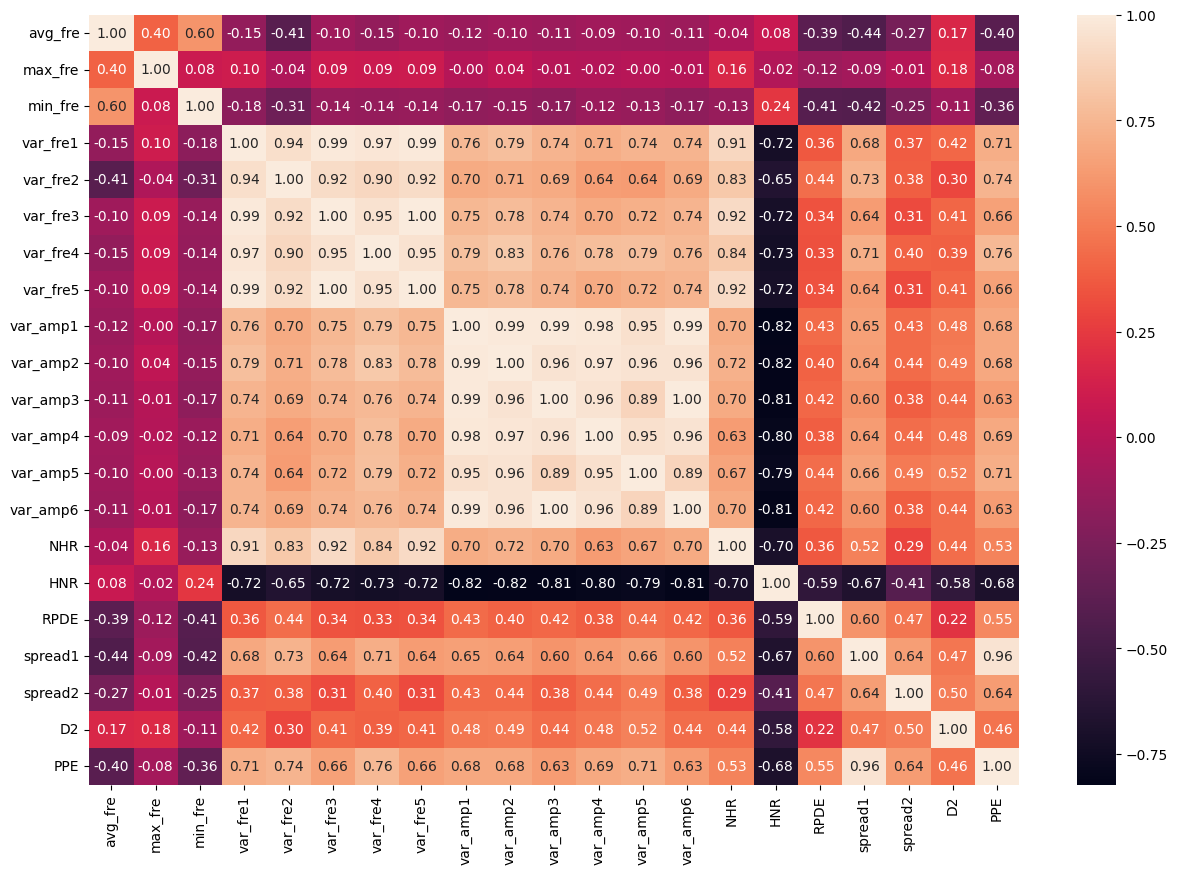


 Correlation Matrix for Italian:


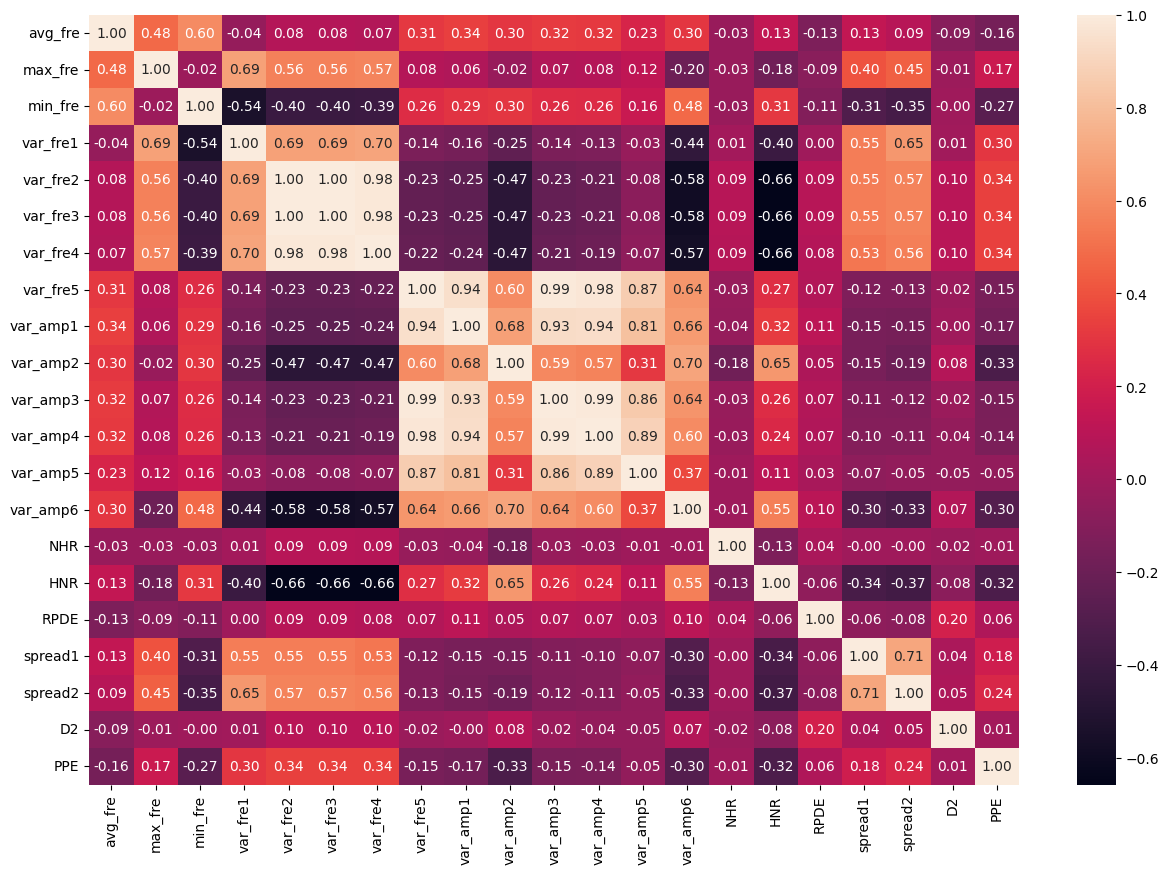


 Correlation Matrix for Merged Data:


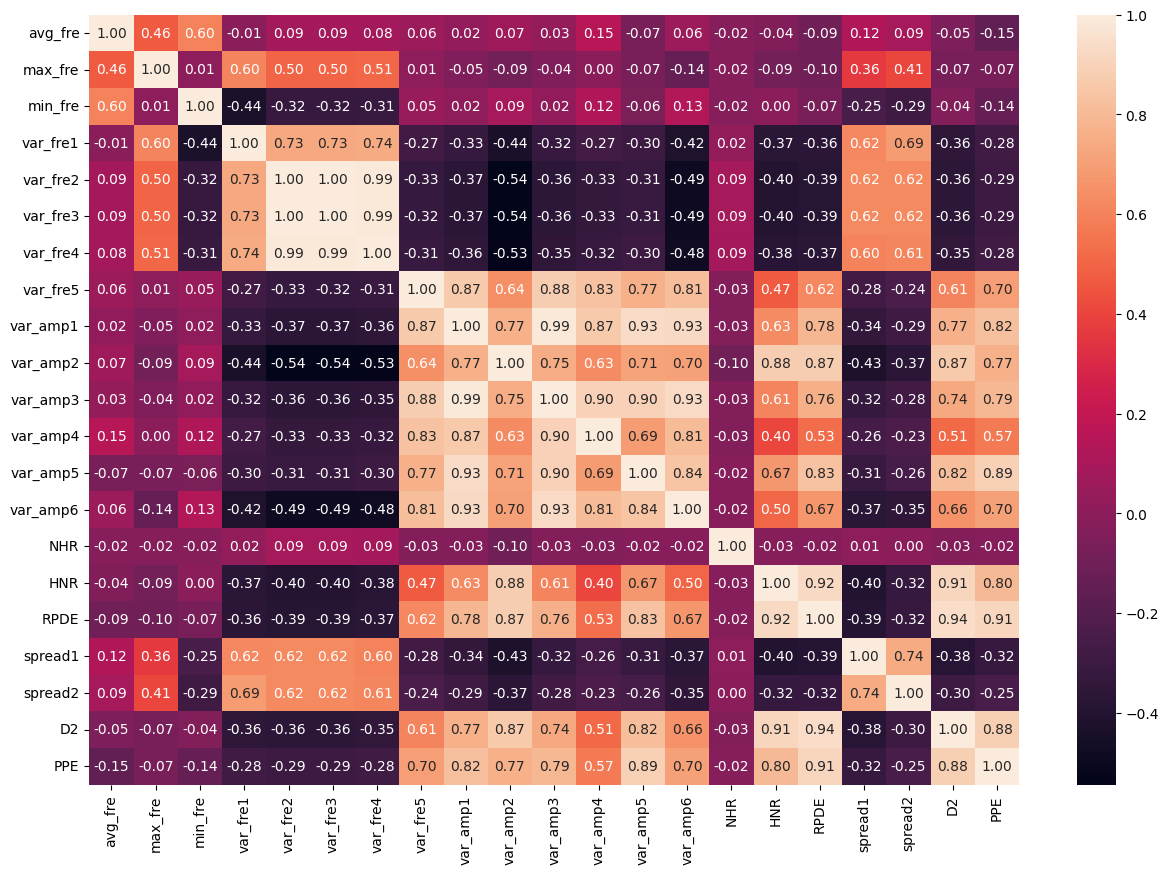

In [13]:
# Analyze Features (optional)
# Correlation Matrix
correlation_matrix = X_english.corr()
print("\n Correlation Matrix for English Data:")
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

correlation_matrix = X_italian.corr()
print("\n Correlation Matrix for Italian:")
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

correlation_matrix = X_merged.corr()
print("\n Correlation Matrix for Merged Data:")
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [14]:
# Normalization/Standardization (optional)
scaler = StandardScaler()

X_english = pd.DataFrame(scaler.fit_transform(X_english), columns=X_english.columns)
X_italian = pd.DataFrame(scaler.fit_transform(X_italian), columns=X_italian.columns)
X_merged = pd.DataFrame(scaler.fit_transform(X_merged), columns=X_merged.columns)

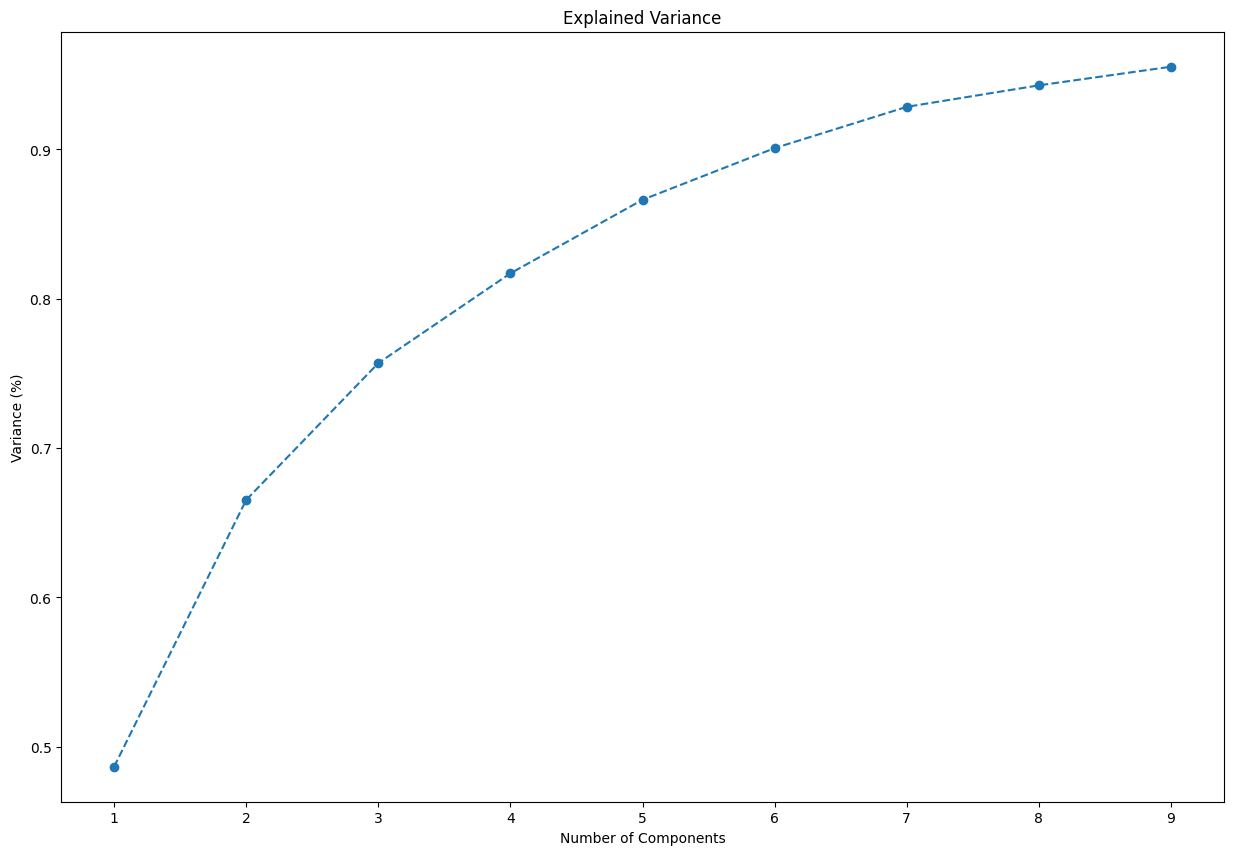

In [15]:
# PCA
pca = PCA(n_components=0.95)

X_english_pca = pca.fit_transform(X_english)
X_italian_pca = pca.fit_transform(X_italian)
X_merged_pca = pca.fit_transform(X_merged)

plt.figure(figsize=(15, 10))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

In [16]:
# Split dataset into train and test sets
X_train_english, X_test_english, y_train_english, y_test_english = train_test_split(X_english, y_english, test_size=0.2, random_state=42)
X_train_italian, X_test_italian, y_train_italian, y_test_italian = train_test_split(X_italian, y_italian, test_size=0.2, random_state=42)
X_train_merged, X_test_merged, y_train_merged, y_test_merged = train_test_split(X_merged, y_merged, test_size=0.2, random_state=42)

In [17]:
#Data Augmentation

smote = SMOTE(random_state=42)
X_train_english_smote, y_train_english_smote = smote.fit_resample(X_train_english, y_train_english)
X_train_italian_smote, y_train_italian_smote = smote.fit_resample(X_train_italian, y_train_italian)
X_train_merged_smote, y_train_merged_smote = smote.fit_resample(X_train_merged, y_train_merged)

In [18]:
X_train_english_smote

,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,var_amp2,...,var_amp4,var_amp5,var_amp6,NHR,HNR,RPDE,spread1,spread2,D2,PPE
0,-1.275510,-0.943857,-0.478435,-0.011598,0.479653,0.093047,0.039891,0.092976,-0.276249,-0.329663,...,-0.293189,-0.378758,-0.177733,-0.294124,-0.336665,0.549186,0.642796,-0.943971,0.152419,0.678639
1,1.131645,0.295978,-0.615363,0.020799,-0.395205,0.163368,-0.002552,0.162126,-0.353467,-0.377947,...,-0.277678,-0.316964,-0.359389,-0.430405,0.295251,-0.596526,0.422309,0.385515,0.480641,0.315355
2,1.987955,0.520972,-0.328442,-0.722173,-0.978443,-0.599614,-0.712509,-0.599699,-0.264749,-0.324298,...,-0.288880,-0.458295,-0.138228,-0.451882,0.491395,-0.269378,-1.032860,-0.636543,-0.364335,-0.960172
3,1.149743,0.150010,1.827816,-0.892798,-0.978443,-0.771901,-0.859131,-0.773161,-0.951493,-0.914438,...,-0.862781,-0.864543,-0.973239,-0.575890,2.280770,-1.484205,-1.931127,-0.661881,0.202615,-1.661312
4,-0.980968,-0.723541,-0.362178,-0.236217,-0.103586,-0.237461,-0.099014,-0.236367,1.285630,1.065214,...,1.366471,1.079209,1.367021,0.333076,-1.222468,1.233099,0.985993,0.964059,0.805507,0.788497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,1.714374,0.459341,2.185651,-0.794229,-0.989134,-0.655627,-0.791085,-0.654971,-0.742944,-0.742039,...,-0.610606,-0.757140,-0.724653,-0.527224,0.954969,-1.596834,-1.354680,-1.737700,-0.518375,-1.268634
222,2.117331,0.566172,2.648087,-0.843005,-1.003857,-0.728008,-0.765318,-0.727945,-0.812435,-0.799402,...,-0.724260,-0.806563,-0.766344,-0.497711,0.810885,-0.800939,-1.281263,-1.729636,-0.051112,-1.275660
223,2.051959,0.581478,2.538009,-0.703531,-0.978443,-0.575866,-0.626370,-0.576181,-0.661391,-0.632863,...,-0.643241,-0.754941,-0.544282,-0.434452,0.263304,-1.554779,-1.466428,-1.461261,0.108746,-1.233292
224,0.976197,1.859282,-0.958654,0.527648,0.114044,0.326473,0.327204,0.325672,-0.346764,-0.180526,...,-0.372286,-0.469467,-0.285151,1.402997,-0.740672,-0.528934,-0.973489,-0.320375,-0.352625,-0.901120


# 3. Model Training & Evaluation
#### Repeat for each algorithm:

## Random Forest

Random Forest Evaluation for English data:


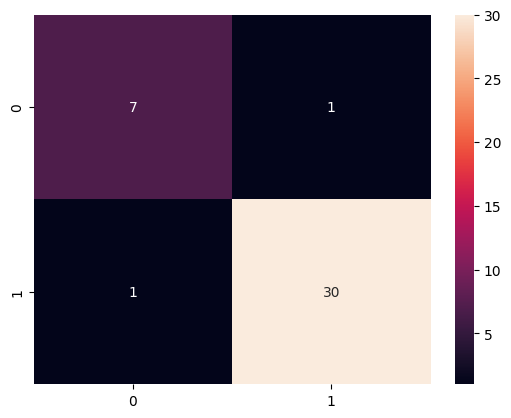

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.97      0.97      0.97        31

    accuracy                           0.95        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.95      0.95      0.95        39

Random Forest Evaluation for Italian data:


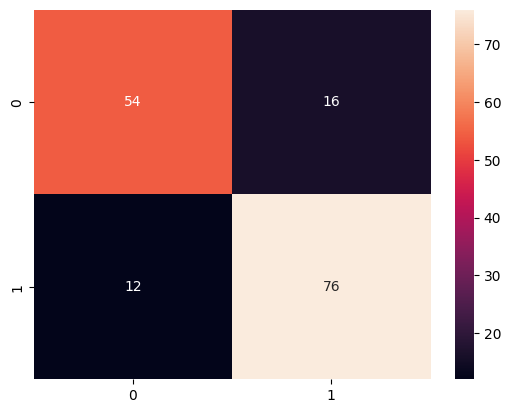

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79        70
         1.0       0.83      0.86      0.84        88

    accuracy                           0.82       158
   macro avg       0.82      0.82      0.82       158
weighted avg       0.82      0.82      0.82       158

Random Forest Evaluation for Merged data:


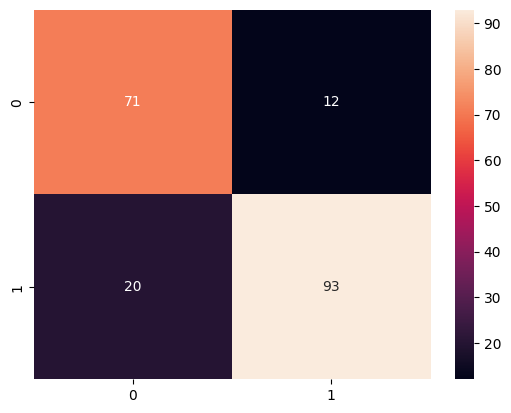

              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        83
         1.0       0.89      0.82      0.85       113

    accuracy                           0.84       196
   macro avg       0.83      0.84      0.83       196
weighted avg       0.84      0.84      0.84       196

Random Forest Evaluation for Italian data on English data trained model:


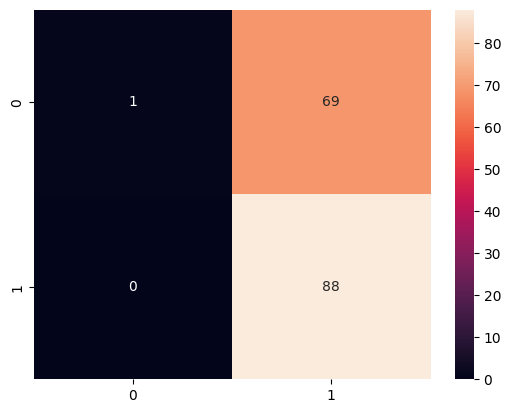

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.03        70
         1.0       0.56      1.00      0.72        88

    accuracy                           0.56       158
   macro avg       0.78      0.51      0.37       158
weighted avg       0.76      0.56      0.41       158

Random Forest Evaluation for English data on Italian data trained model:


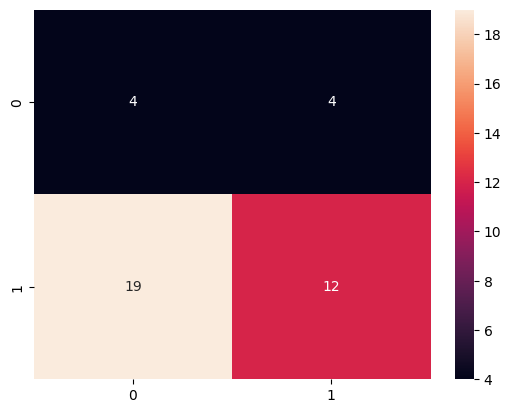

              precision    recall  f1-score   support

         0.0       0.17      0.50      0.26         8
         1.0       0.75      0.39      0.51        31

    accuracy                           0.41        39
   macro avg       0.46      0.44      0.38        39
weighted avg       0.63      0.41      0.46        39

Random Forest Evaluation for Merged data on English data trained model:


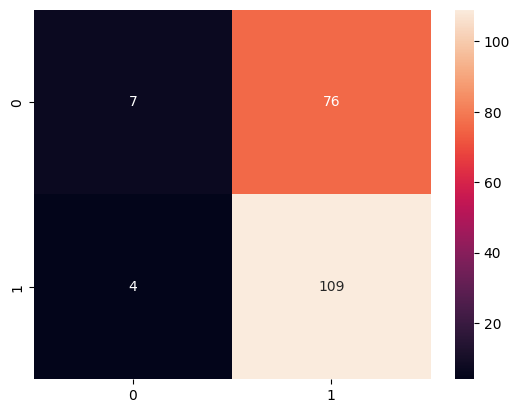

              precision    recall  f1-score   support

         0.0       0.64      0.08      0.15        83
         1.0       0.59      0.96      0.73       113

    accuracy                           0.59       196
   macro avg       0.61      0.52      0.44       196
weighted avg       0.61      0.59      0.48       196

Random Forest Evaluation for Merged data on Italian data trained model:


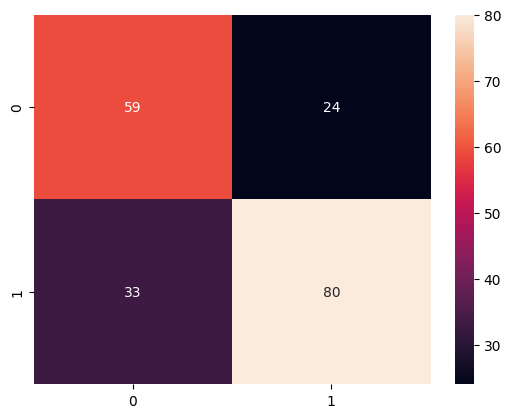

              precision    recall  f1-score   support

         0.0       0.64      0.71      0.67        83
         1.0       0.77      0.71      0.74       113

    accuracy                           0.71       196
   macro avg       0.71      0.71      0.71       196
weighted avg       0.72      0.71      0.71       196

Random Forest Evaluation for English data on Merged data trained model:


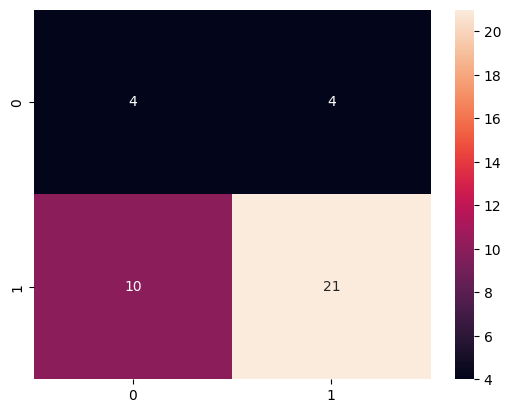

              precision    recall  f1-score   support

         0.0       0.29      0.50      0.36         8
         1.0       0.84      0.68      0.75        31

    accuracy                           0.64        39
   macro avg       0.56      0.59      0.56        39
weighted avg       0.73      0.64      0.67        39

Random Forest Evaluation for Italian data on Merged data trained model:


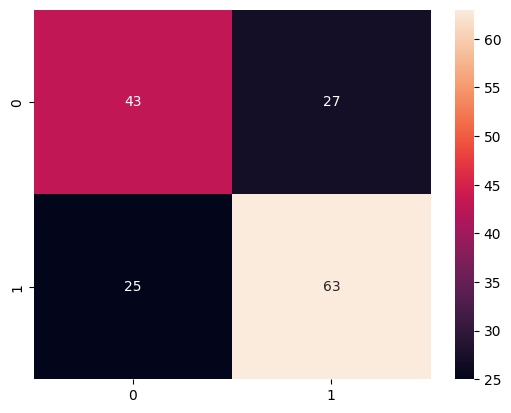

              precision    recall  f1-score   support

         0.0       0.63      0.61      0.62        70
         1.0       0.70      0.72      0.71        88

    accuracy                           0.67       158
   macro avg       0.67      0.67      0.67       158
weighted avg       0.67      0.67      0.67       158



In [19]:
# Model Training for English data
rf_english = RandomForestClassifier()
rf_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
rf_italian = RandomForestClassifier()
rf_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
rf_merged = RandomForestClassifier()
rf_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = rf_english.predict(X_test_english)
print("Random Forest Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = rf_italian.predict(X_test_italian)
print("Random Forest Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = rf_merged.predict(X_test_merged)
print("Random Forest Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = rf_english.predict(X_test_italian)
print("Random Forest Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = rf_italian.predict(X_test_english)
print("Random Forest Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = rf_english.predict(X_test_merged)
print("Random Forest Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = rf_italian.predict(X_test_merged)
print("Random Forest Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = rf_merged.predict(X_test_english)
print("Random Forest Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = rf_merged.predict(X_test_italian)
print("Random Forest Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

## LightGBM

LightGBM Evaluation for English data:


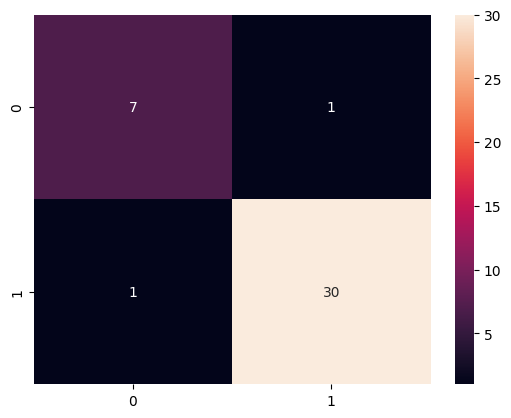

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.97      0.97      0.97        31

    accuracy                           0.95        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.95      0.95      0.95        39

LightGBM Evaluation for Italian data:


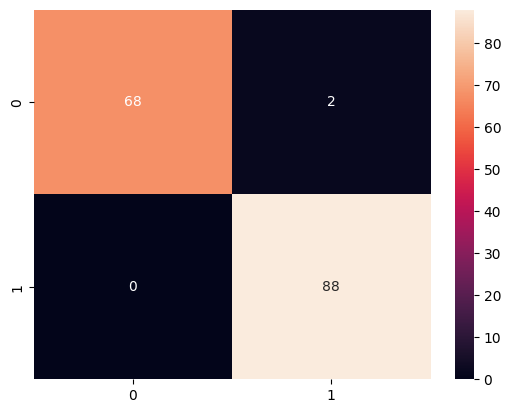

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        70
         1.0       0.98      1.00      0.99        88

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158

LightGBM Evaluation for Merged data:


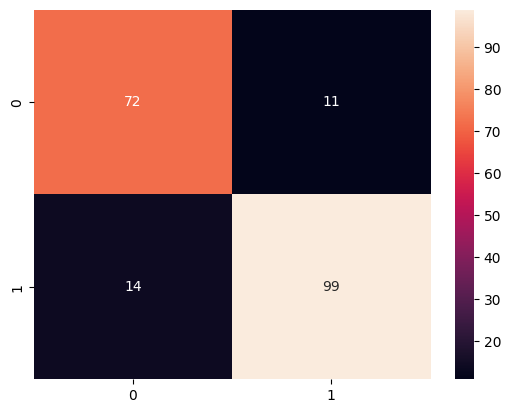

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85        83
         1.0       0.90      0.88      0.89       113

    accuracy                           0.87       196
   macro avg       0.87      0.87      0.87       196
weighted avg       0.87      0.87      0.87       196

LightGBM Evaluation for Italian data on English data trained model:


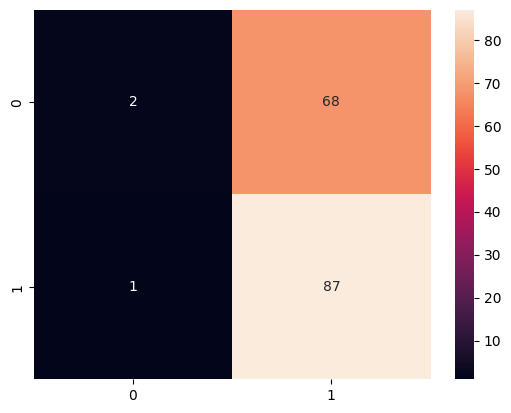

              precision    recall  f1-score   support

         0.0       0.67      0.03      0.05        70
         1.0       0.56      0.99      0.72        88

    accuracy                           0.56       158
   macro avg       0.61      0.51      0.39       158
weighted avg       0.61      0.56      0.42       158

LightGBM Evaluation for English data on Italian data trained model:


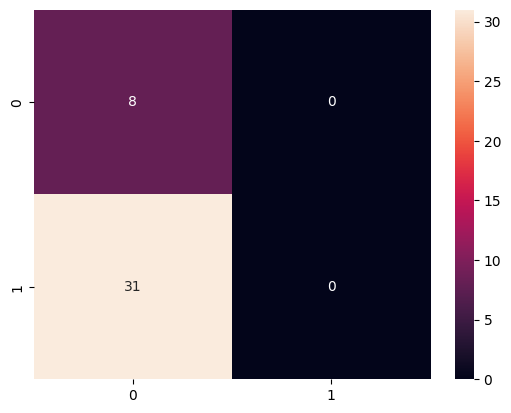

              precision    recall  f1-score   support

         0.0       0.21      1.00      0.34         8
         1.0       0.00      0.00      0.00        31

    accuracy                           0.21        39
   macro avg       0.10      0.50      0.17        39
weighted avg       0.04      0.21      0.07        39

LightGBM Evaluation for Merged data on English data trained model:


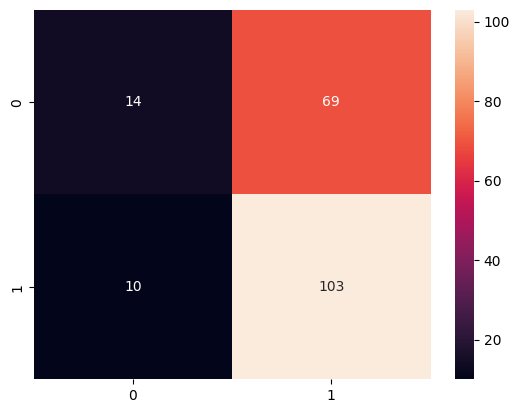

              precision    recall  f1-score   support

         0.0       0.58      0.17      0.26        83
         1.0       0.60      0.91      0.72       113

    accuracy                           0.60       196
   macro avg       0.59      0.54      0.49       196
weighted avg       0.59      0.60      0.53       196

LightGBM Evaluation for Merged data on Italian data trained model:


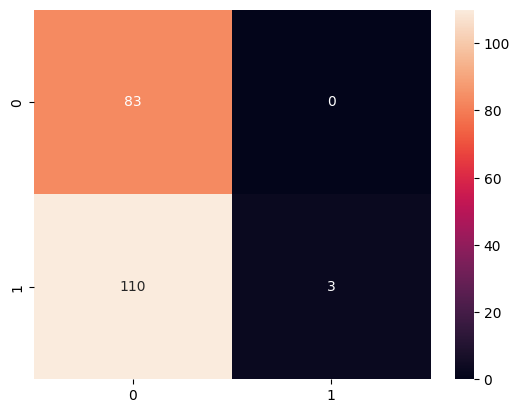

              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60        83
         1.0       1.00      0.03      0.05       113

    accuracy                           0.44       196
   macro avg       0.72      0.51      0.33       196
weighted avg       0.76      0.44      0.28       196

LightGBM Evaluation for English data on Merged data trained model:


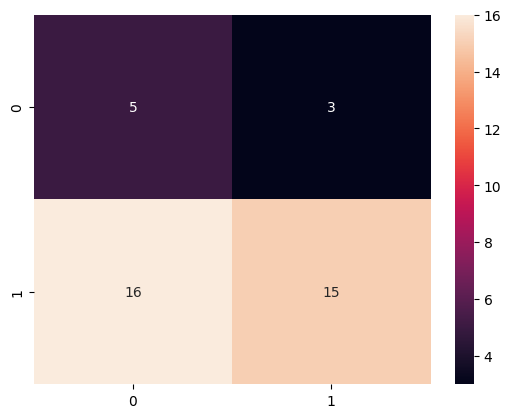

              precision    recall  f1-score   support

         0.0       0.24      0.62      0.34         8
         1.0       0.83      0.48      0.61        31

    accuracy                           0.51        39
   macro avg       0.54      0.55      0.48        39
weighted avg       0.71      0.51      0.56        39

LightGBM Evaluation for Italian data on Merged data trained model:


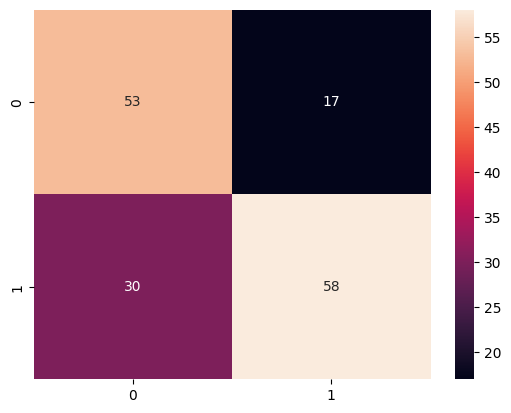

              precision    recall  f1-score   support

         0.0       0.64      0.76      0.69        70
         1.0       0.77      0.66      0.71        88

    accuracy                           0.70       158
   macro avg       0.71      0.71      0.70       158
weighted avg       0.71      0.70      0.70       158



In [20]:
# Model Training for English data
lgb_english = lgb.LGBMClassifier(verbose=-1)
lgb_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
lgb_italian = lgb.LGBMClassifier(verbose=-1)
lgb_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
lgb_merged = lgb.LGBMClassifier(verbose=-1)
lgb_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = lgb_english.predict(X_test_english)
print("LightGBM Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = lgb_italian.predict(X_test_italian)
print("LightGBM Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = lgb_merged.predict(X_test_merged)
print("LightGBM Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = lgb_english.predict(X_test_italian)
print("LightGBM Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = lgb_italian.predict(X_test_english)
print("LightGBM Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = lgb_english.predict(X_test_merged)
print("LightGBM Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = lgb_italian.predict(X_test_merged)
print("LightGBM Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = lgb_merged.predict(X_test_english)
print("LightGBM Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = lgb_merged.predict(X_test_italian)
print("LightGBM Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

## CatBoost

CatBoost Evaluation for English data:


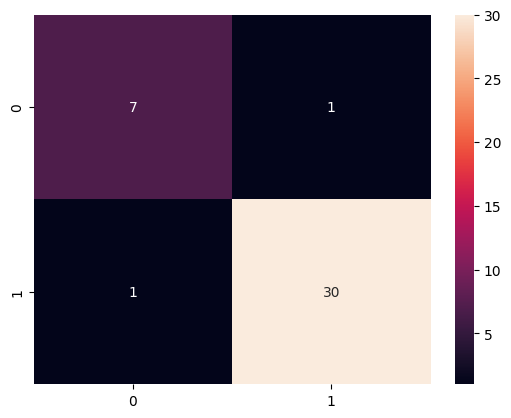

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.97      0.97      0.97        31

    accuracy                           0.95        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.95      0.95      0.95        39

CatBoost Evaluation for Italian data:


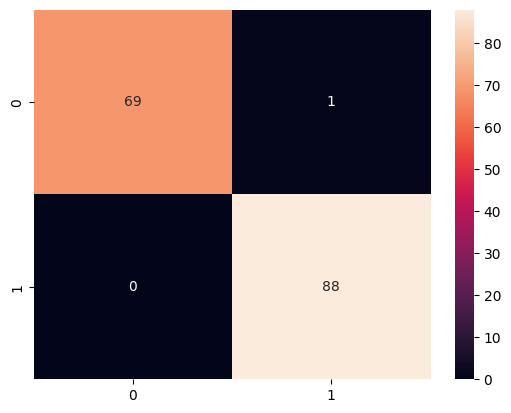

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        70
         1.0       0.99      1.00      0.99        88

    accuracy                           0.99       158
   macro avg       0.99      0.99      0.99       158
weighted avg       0.99      0.99      0.99       158

CatBoost Evaluation for Merged data:


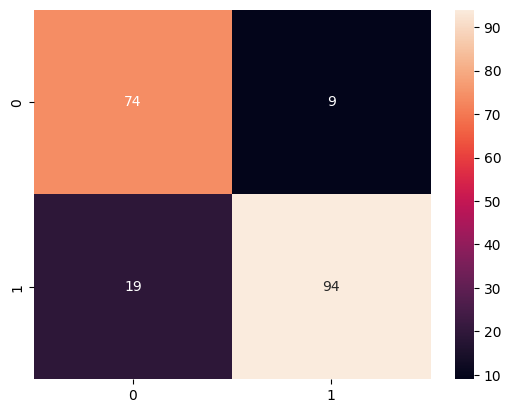

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        83
         1.0       0.91      0.83      0.87       113

    accuracy                           0.86       196
   macro avg       0.85      0.86      0.86       196
weighted avg       0.86      0.86      0.86       196

CatBoost Evaluation for Italian data on English data trained model:


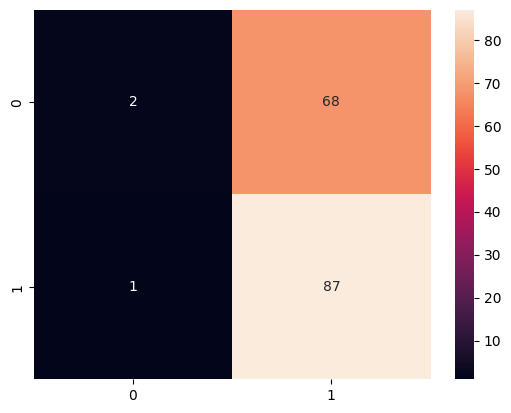

              precision    recall  f1-score   support

         0.0       0.67      0.03      0.05        70
         1.0       0.56      0.99      0.72        88

    accuracy                           0.56       158
   macro avg       0.61      0.51      0.39       158
weighted avg       0.61      0.56      0.42       158

CatBoost Evaluation for English data on Italian data trained model:


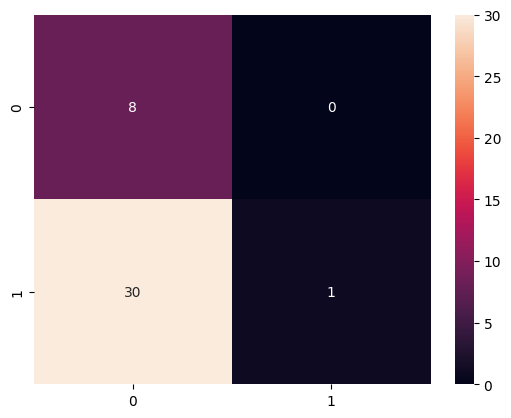

              precision    recall  f1-score   support

         0.0       0.21      1.00      0.35         8
         1.0       1.00      0.03      0.06        31

    accuracy                           0.23        39
   macro avg       0.61      0.52      0.21        39
weighted avg       0.84      0.23      0.12        39

CatBoost Evaluation for Merged data on English data trained model:


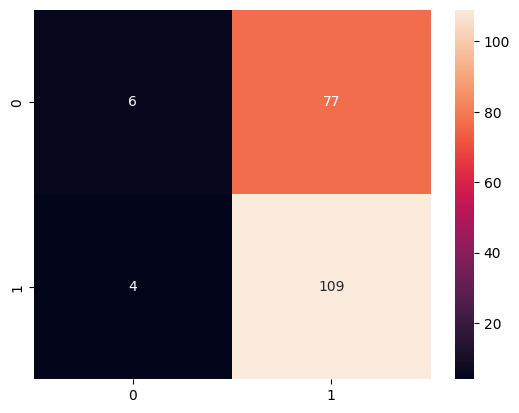

              precision    recall  f1-score   support

         0.0       0.60      0.07      0.13        83
         1.0       0.59      0.96      0.73       113

    accuracy                           0.59       196
   macro avg       0.59      0.52      0.43       196
weighted avg       0.59      0.59      0.47       196

CatBoost Evaluation for Merged data on Italian data trained model:


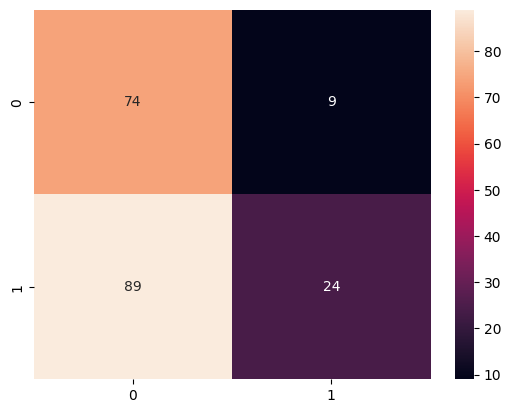

              precision    recall  f1-score   support

         0.0       0.45      0.89      0.60        83
         1.0       0.73      0.21      0.33       113

    accuracy                           0.50       196
   macro avg       0.59      0.55      0.47       196
weighted avg       0.61      0.50      0.44       196

CatBoost Evaluation for English data on Merged data trained model:


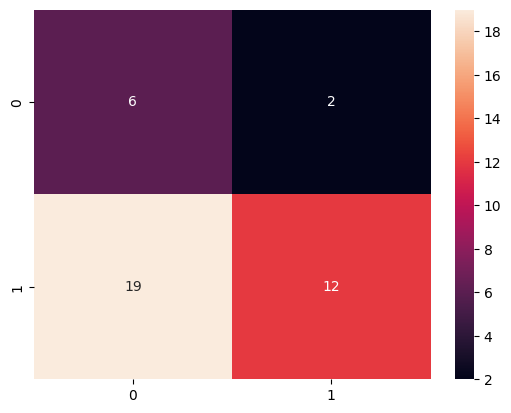

              precision    recall  f1-score   support

         0.0       0.24      0.75      0.36         8
         1.0       0.86      0.39      0.53        31

    accuracy                           0.46        39
   macro avg       0.55      0.57      0.45        39
weighted avg       0.73      0.46      0.50        39

CatBoost Evaluation for Italian data on Merged data trained model:


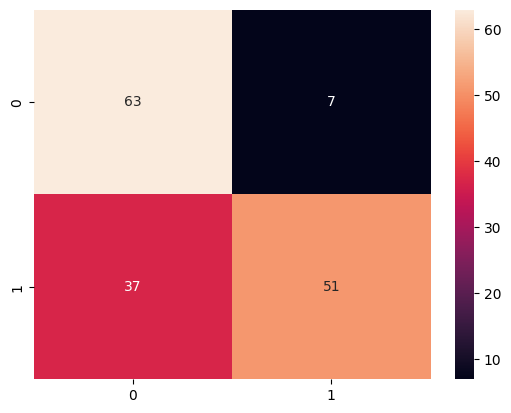

              precision    recall  f1-score   support

         0.0       0.63      0.90      0.74        70
         1.0       0.88      0.58      0.70        88

    accuracy                           0.72       158
   macro avg       0.75      0.74      0.72       158
weighted avg       0.77      0.72      0.72       158



In [21]:
from catboost import CatBoostClassifier

# Model Training for English data
cat_english = CatBoostClassifier(verbose=False)
cat_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
cat_italian = CatBoostClassifier(verbose=False)
cat_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
cat_merged = CatBoostClassifier(verbose=False)
cat_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = cat_english.predict(X_test_english)
print("CatBoost Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = cat_italian.predict(X_test_italian)
print("CatBoost Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = cat_merged.predict(X_test_merged)
print("CatBoost Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = cat_english.predict(X_test_italian)
print("CatBoost Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = cat_italian.predict(X_test_english)
print("CatBoost Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = cat_english.predict(X_test_merged)
print("CatBoost Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = cat_italian.predict(X_test_merged)
print("CatBoost Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = cat_merged.predict(X_test_english)
print("CatBoost Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = cat_merged.predict(X_test_italian)
print("CatBoost Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

SVM Evaluation for English data:


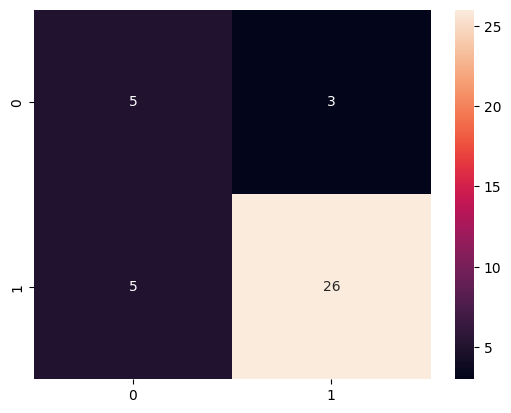

              precision    recall  f1-score   support

         0.0       0.50      0.62      0.56         8
         1.0       0.90      0.84      0.87        31

    accuracy                           0.79        39
   macro avg       0.70      0.73      0.71        39
weighted avg       0.82      0.79      0.80        39

SVM Evaluation for Italian data:


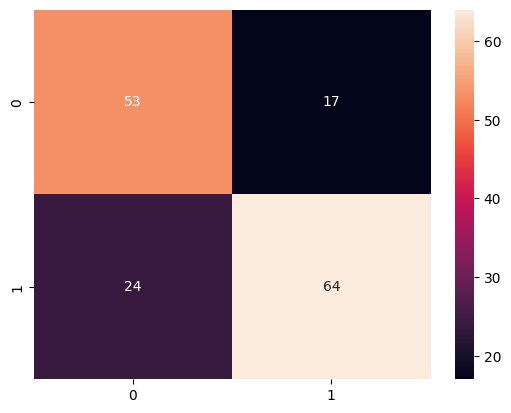

              precision    recall  f1-score   support

         0.0       0.69      0.76      0.72        70
         1.0       0.79      0.73      0.76        88

    accuracy                           0.74       158
   macro avg       0.74      0.74      0.74       158
weighted avg       0.75      0.74      0.74       158

SVM Evaluation for Merged data:


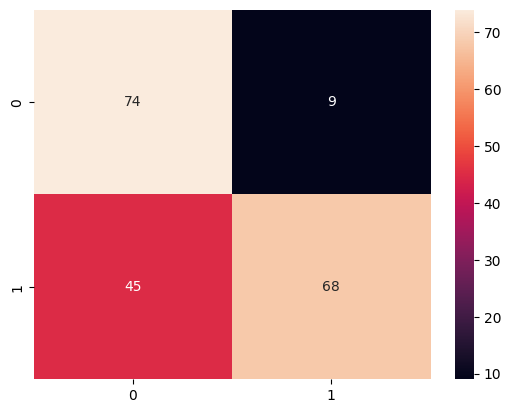

              precision    recall  f1-score   support

         0.0       0.62      0.89      0.73        83
         1.0       0.88      0.60      0.72       113

    accuracy                           0.72       196
   macro avg       0.75      0.75      0.72       196
weighted avg       0.77      0.72      0.72       196

SVM Evaluation for Italian data on English data trained model:


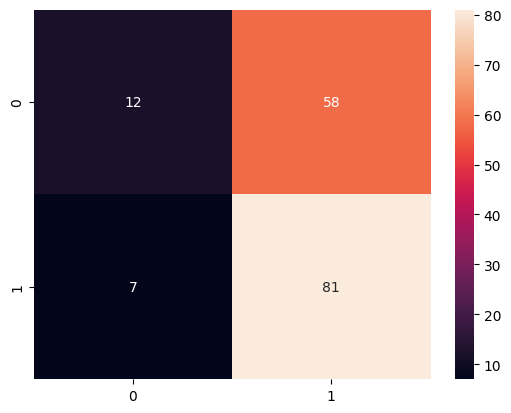

              precision    recall  f1-score   support

         0.0       0.63      0.17      0.27        70
         1.0       0.58      0.92      0.71        88

    accuracy                           0.59       158
   macro avg       0.61      0.55      0.49       158
weighted avg       0.60      0.59      0.52       158

SVM Evaluation for English data on Italian data trained model:


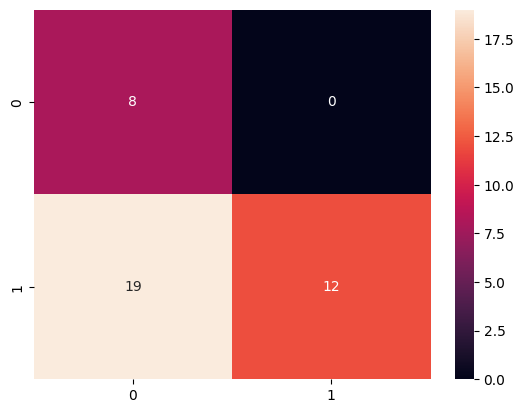

              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46         8
         1.0       1.00      0.39      0.56        31

    accuracy                           0.51        39
   macro avg       0.65      0.69      0.51        39
weighted avg       0.86      0.51      0.54        39

SVM Evaluation for Merged data on English data trained model:


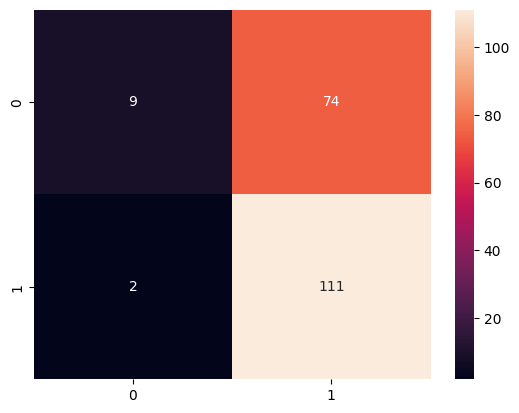

              precision    recall  f1-score   support

         0.0       0.82      0.11      0.19        83
         1.0       0.60      0.98      0.74       113

    accuracy                           0.61       196
   macro avg       0.71      0.55      0.47       196
weighted avg       0.69      0.61      0.51       196

SVM Evaluation for Merged data on Italian data trained model:


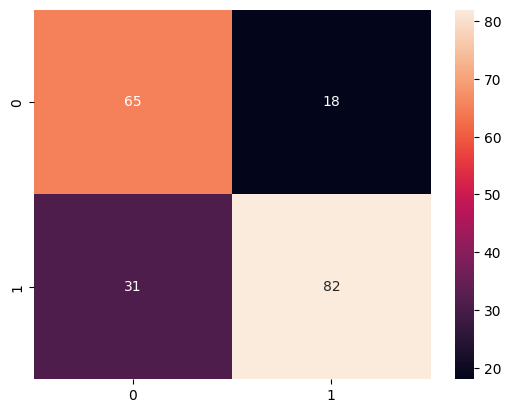

              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73        83
         1.0       0.82      0.73      0.77       113

    accuracy                           0.75       196
   macro avg       0.75      0.75      0.75       196
weighted avg       0.76      0.75      0.75       196

SVM Evaluation for English data on Merged data trained model:


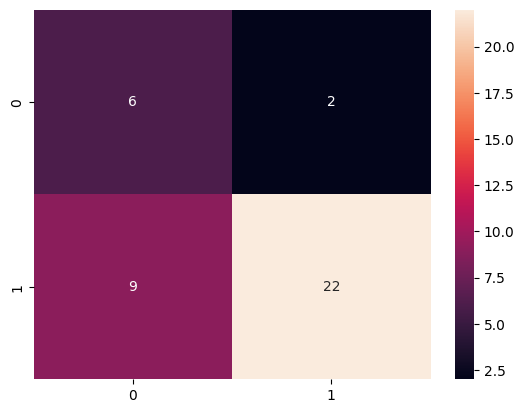

              precision    recall  f1-score   support

         0.0       0.40      0.75      0.52         8
         1.0       0.92      0.71      0.80        31

    accuracy                           0.72        39
   macro avg       0.66      0.73      0.66        39
weighted avg       0.81      0.72      0.74        39

SVM Evaluation for Italian data on Merged data trained model:


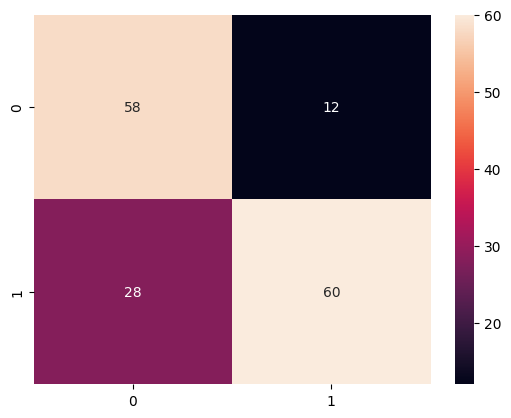

              precision    recall  f1-score   support

         0.0       0.67      0.83      0.74        70
         1.0       0.83      0.68      0.75        88

    accuracy                           0.75       158
   macro avg       0.75      0.76      0.75       158
weighted avg       0.76      0.75      0.75       158



In [22]:
from sklearn import svm

# Model Training for English data
svm_english = svm.SVC()
svm_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
svm_italian = svm.SVC()
svm_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
svm_merged = svm.SVC()
svm_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = svm_english.predict(X_test_english)
print("SVM Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = svm_italian.predict(X_test_italian)
print("SVM Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = svm_merged.predict(X_test_merged)
print("SVM Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = svm_english.predict(X_test_italian)
print("SVM Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = svm_italian.predict(X_test_english)
print("SVM Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = svm_english.predict(X_test_merged)
print("SVM Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = svm_italian.predict(X_test_merged)
print("SVM Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = svm_merged.predict(X_test_english)
print("SVM Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = svm_merged.predict(X_test_italian)
print("SVM Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

## KNN

KNN Evaluation for English data:


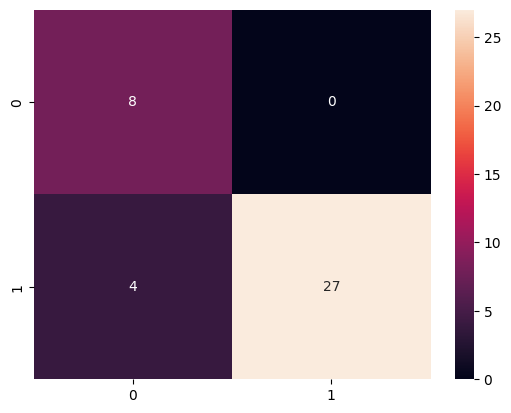

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         8
         1.0       1.00      0.87      0.93        31

    accuracy                           0.90        39
   macro avg       0.83      0.94      0.87        39
weighted avg       0.93      0.90      0.90        39

KNN Evaluation for Italian data:


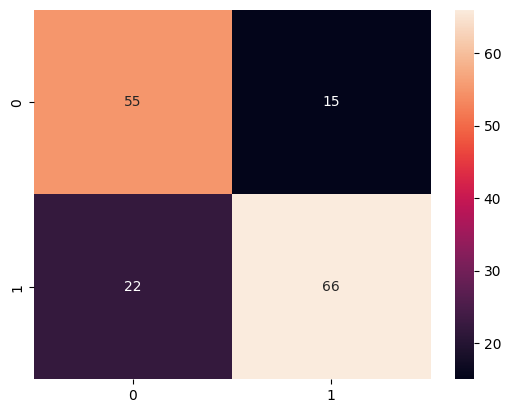

              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75        70
         1.0       0.81      0.75      0.78        88

    accuracy                           0.77       158
   macro avg       0.76      0.77      0.76       158
weighted avg       0.77      0.77      0.77       158

KNN Evaluation for Merged data:


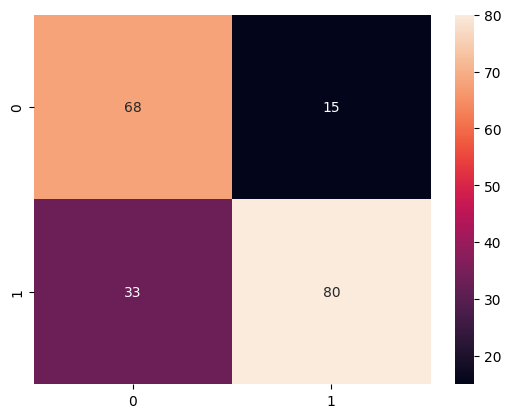

              precision    recall  f1-score   support

         0.0       0.67      0.82      0.74        83
         1.0       0.84      0.71      0.77       113

    accuracy                           0.76       196
   macro avg       0.76      0.76      0.75       196
weighted avg       0.77      0.76      0.76       196

KNN Evaluation for Italian data on English data trained model:


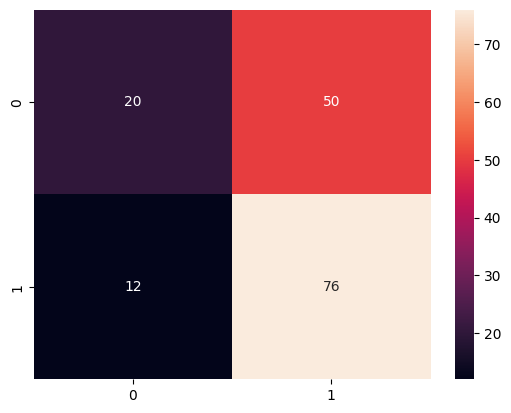

              precision    recall  f1-score   support

         0.0       0.62      0.29      0.39        70
         1.0       0.60      0.86      0.71        88

    accuracy                           0.61       158
   macro avg       0.61      0.57      0.55       158
weighted avg       0.61      0.61      0.57       158

KNN Evaluation for English data on Italian data trained model:


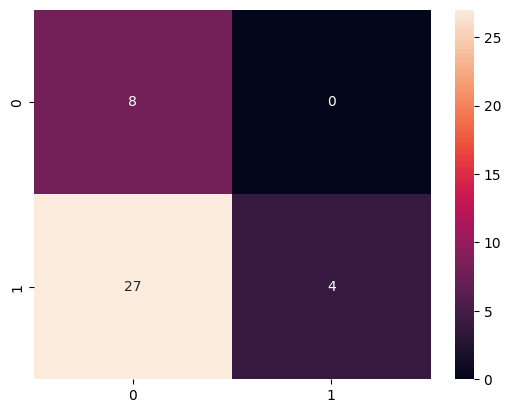

              precision    recall  f1-score   support

         0.0       0.23      1.00      0.37         8
         1.0       1.00      0.13      0.23        31

    accuracy                           0.31        39
   macro avg       0.61      0.56      0.30        39
weighted avg       0.84      0.31      0.26        39

KNN Evaluation for Merged data on English data trained model:


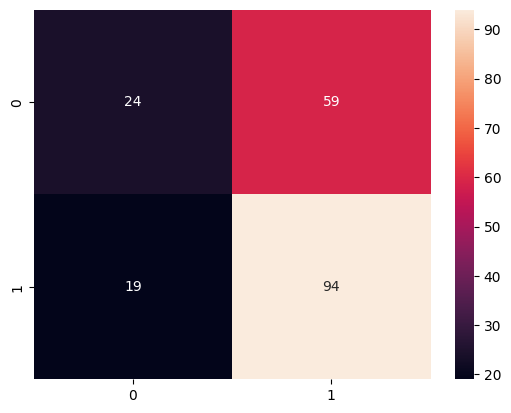

              precision    recall  f1-score   support

         0.0       0.56      0.29      0.38        83
         1.0       0.61      0.83      0.71       113

    accuracy                           0.60       196
   macro avg       0.59      0.56      0.54       196
weighted avg       0.59      0.60      0.57       196

KNN Evaluation for Merged data on Italian data trained model:


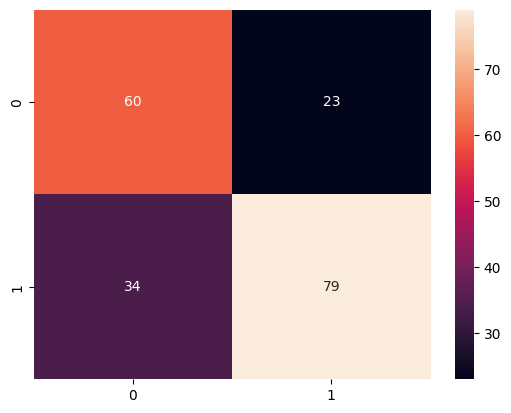

              precision    recall  f1-score   support

         0.0       0.64      0.72      0.68        83
         1.0       0.77      0.70      0.73       113

    accuracy                           0.71       196
   macro avg       0.71      0.71      0.71       196
weighted avg       0.72      0.71      0.71       196

KNN Evaluation for English data on Merged data trained model:


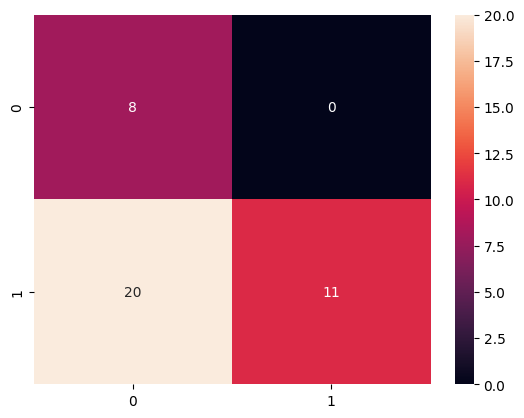

              precision    recall  f1-score   support

         0.0       0.29      1.00      0.44         8
         1.0       1.00      0.35      0.52        31

    accuracy                           0.49        39
   macro avg       0.64      0.68      0.48        39
weighted avg       0.85      0.49      0.51        39

KNN Evaluation for Italian data on Merged data trained model:


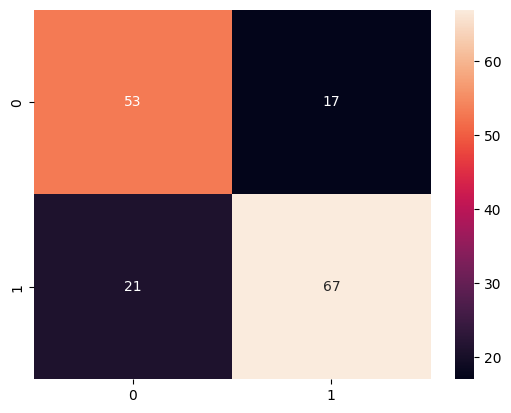

              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74        70
         1.0       0.80      0.76      0.78        88

    accuracy                           0.76       158
   macro avg       0.76      0.76      0.76       158
weighted avg       0.76      0.76      0.76       158



In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Model Training for English data
knn_english = KNeighborsClassifier()
knn_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
knn_italian = KNeighborsClassifier()
knn_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
knn_merged = KNeighborsClassifier()
knn_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = knn_english.predict(X_test_english)
print("KNN Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = knn_italian.predict(X_test_italian)
print("KNN Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = knn_merged.predict(X_test_merged)
print("KNN Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = knn_english.predict(X_test_italian)
print("KNN Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = knn_italian.predict(X_test_english)
print("KNN Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = knn_english.predict(X_test_merged)
print("KNN Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = knn_italian.predict(X_test_merged)
print("KNN Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = knn_merged.predict(X_test_english)
print("KNN Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = knn_merged.predict(X_test_italian)
print("KNN Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

## Extra Trees

Extra Trees Evaluation for English data:


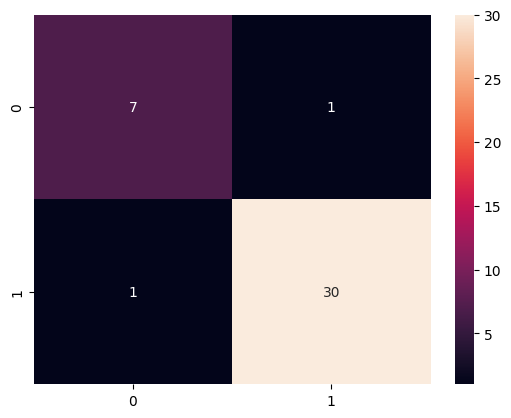

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88         8
         1.0       0.97      0.97      0.97        31

    accuracy                           0.95        39
   macro avg       0.92      0.92      0.92        39
weighted avg       0.95      0.95      0.95        39

Extra Trees Evaluation for Italian data:


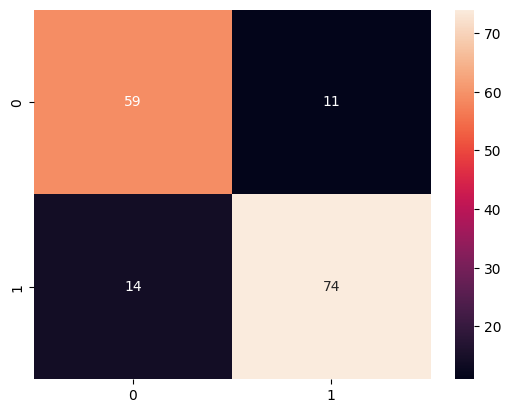

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83        70
         1.0       0.87      0.84      0.86        88

    accuracy                           0.84       158
   macro avg       0.84      0.84      0.84       158
weighted avg       0.84      0.84      0.84       158

Extra Trees Evaluation for Merged data:


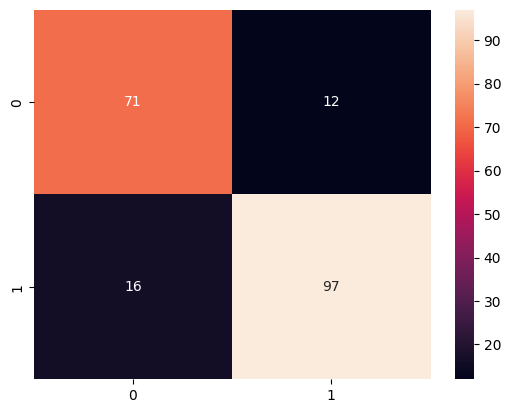

              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84        83
         1.0       0.89      0.86      0.87       113

    accuracy                           0.86       196
   macro avg       0.85      0.86      0.85       196
weighted avg       0.86      0.86      0.86       196

Extra Trees Evaluation for Italian data on English data trained model:


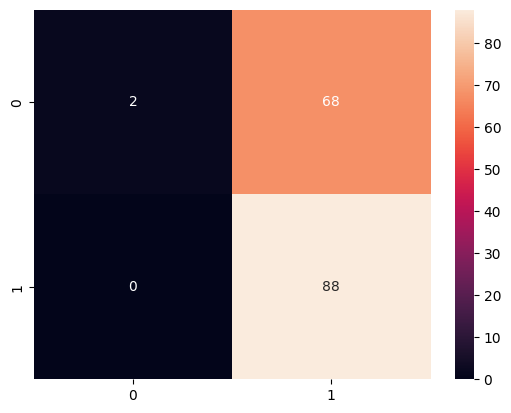

              precision    recall  f1-score   support

         0.0       1.00      0.03      0.06        70
         1.0       0.56      1.00      0.72        88

    accuracy                           0.57       158
   macro avg       0.78      0.51      0.39       158
weighted avg       0.76      0.57      0.43       158

Extra Trees Evaluation for English data on Italian data trained model:


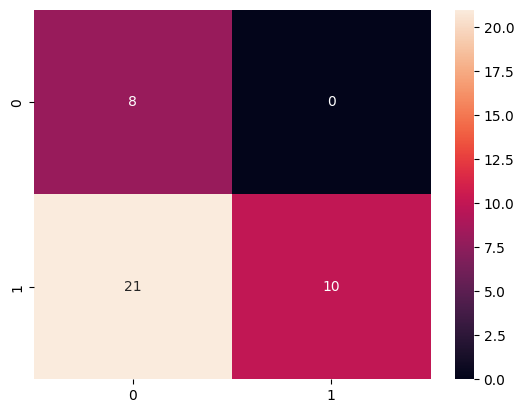

              precision    recall  f1-score   support

         0.0       0.28      1.00      0.43         8
         1.0       1.00      0.32      0.49        31

    accuracy                           0.46        39
   macro avg       0.64      0.66      0.46        39
weighted avg       0.85      0.46      0.48        39

Extra Trees Evaluation for Merged data on English data trained model:


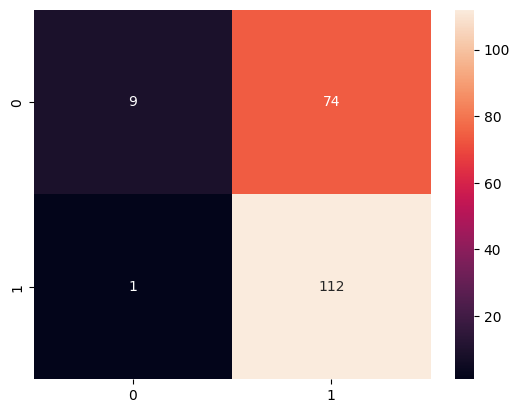

              precision    recall  f1-score   support

         0.0       0.90      0.11      0.19        83
         1.0       0.60      0.99      0.75       113

    accuracy                           0.62       196
   macro avg       0.75      0.55      0.47       196
weighted avg       0.73      0.62      0.51       196

Extra Trees Evaluation for Merged data on Italian data trained model:


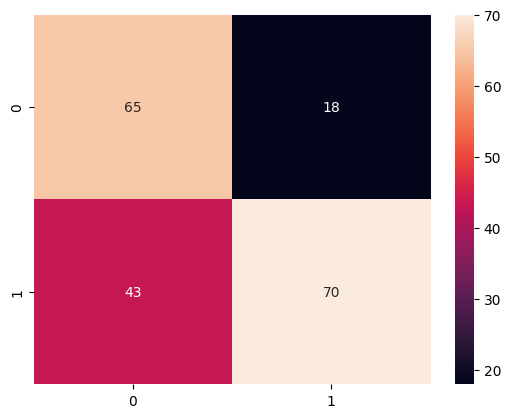

              precision    recall  f1-score   support

         0.0       0.60      0.78      0.68        83
         1.0       0.80      0.62      0.70       113

    accuracy                           0.69       196
   macro avg       0.70      0.70      0.69       196
weighted avg       0.71      0.69      0.69       196

Extra Trees Evaluation for English data on Merged data trained model:


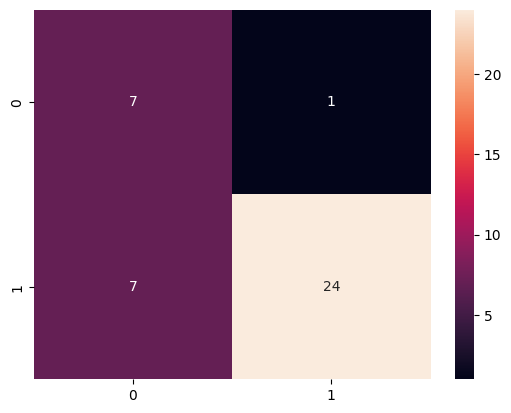

              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64         8
         1.0       0.96      0.77      0.86        31

    accuracy                           0.79        39
   macro avg       0.73      0.82      0.75        39
weighted avg       0.87      0.79      0.81        39

Extra Trees Evaluation for Italian data on Merged data trained model:


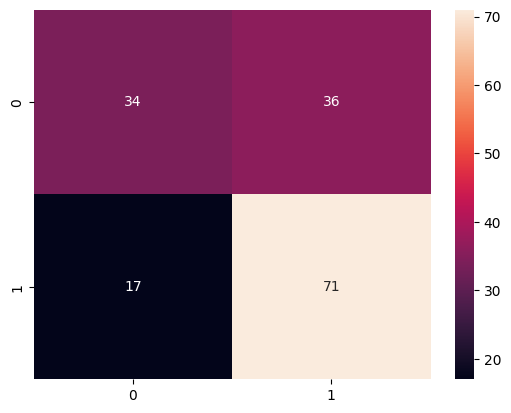

              precision    recall  f1-score   support

         0.0       0.67      0.49      0.56        70
         1.0       0.66      0.81      0.73        88

    accuracy                           0.66       158
   macro avg       0.67      0.65      0.65       158
weighted avg       0.66      0.66      0.65       158



In [24]:
from sklearn.ensemble import ExtraTreesClassifier

# Model Training for English data
et_english = ExtraTreesClassifier()
et_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
et_italian = ExtraTreesClassifier()
et_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
et_merged = ExtraTreesClassifier()
et_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = et_english.predict(X_test_english)
print("Extra Trees Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = et_italian.predict(X_test_italian)
print("Extra Trees Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = et_merged.predict(X_test_merged)
print("Extra Trees Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = et_english.predict(X_test_italian)
print("Extra Trees Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = et_italian.predict(X_test_english)
print("Extra Trees Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = et_english.predict(X_test_merged)
print("Extra Trees Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = et_italian.predict(X_test_merged)
print("Extra Trees Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = et_merged.predict(X_test_english)
print("Extra Trees Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = et_merged.predict(X_test_italian)
print("Extra Trees Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

## Logistic Regression

Logistic Regression Evaluation for English data:


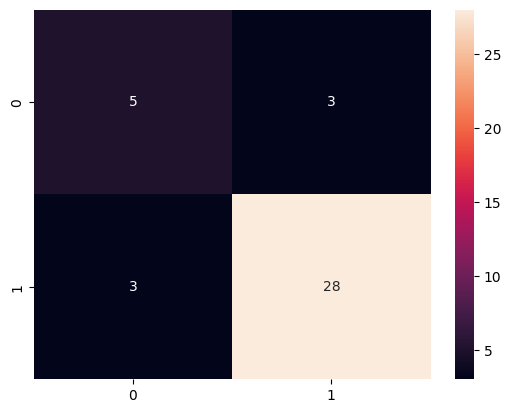

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62         8
         1.0       0.90      0.90      0.90        31

    accuracy                           0.85        39
   macro avg       0.76      0.76      0.76        39
weighted avg       0.85      0.85      0.85        39

Logistic Regression Evaluation for Italian data:


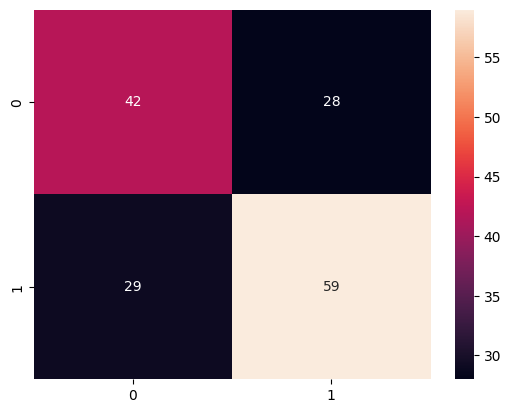

              precision    recall  f1-score   support

         0.0       0.59      0.60      0.60        70
         1.0       0.68      0.67      0.67        88

    accuracy                           0.64       158
   macro avg       0.63      0.64      0.64       158
weighted avg       0.64      0.64      0.64       158

Logistic Regression Evaluation for Merged data:


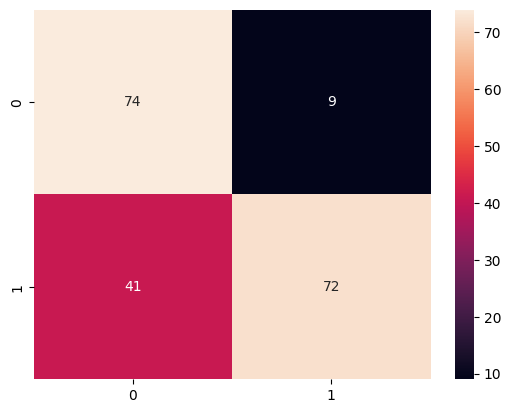

              precision    recall  f1-score   support

         0.0       0.64      0.89      0.75        83
         1.0       0.89      0.64      0.74       113

    accuracy                           0.74       196
   macro avg       0.77      0.76      0.74       196
weighted avg       0.78      0.74      0.74       196

Logistic Regression Evaluation for Italian data on English data trained model:


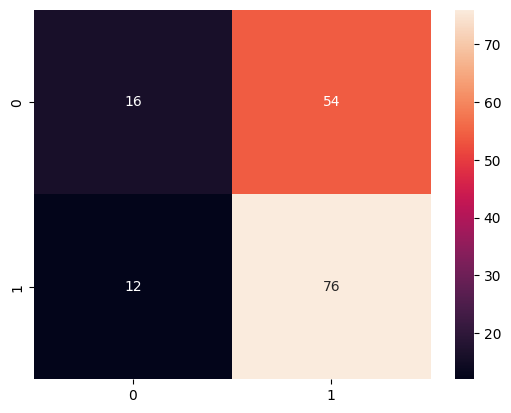

              precision    recall  f1-score   support

         0.0       0.57      0.23      0.33        70
         1.0       0.58      0.86      0.70        88

    accuracy                           0.58       158
   macro avg       0.58      0.55      0.51       158
weighted avg       0.58      0.58      0.53       158

Logistic Regression Evaluation for English data on Italian data trained model:


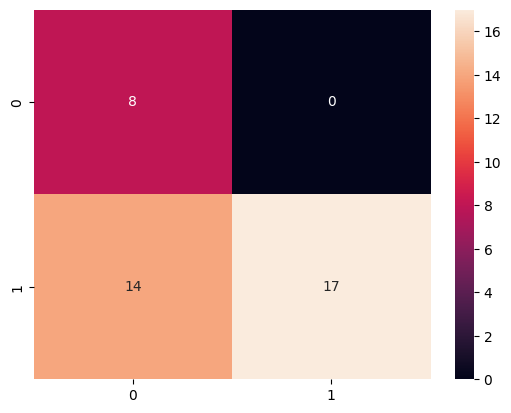

              precision    recall  f1-score   support

         0.0       0.36      1.00      0.53         8
         1.0       1.00      0.55      0.71        31

    accuracy                           0.64        39
   macro avg       0.68      0.77      0.62        39
weighted avg       0.87      0.64      0.67        39

Logistic Regression Evaluation for Merged data on English data trained model:


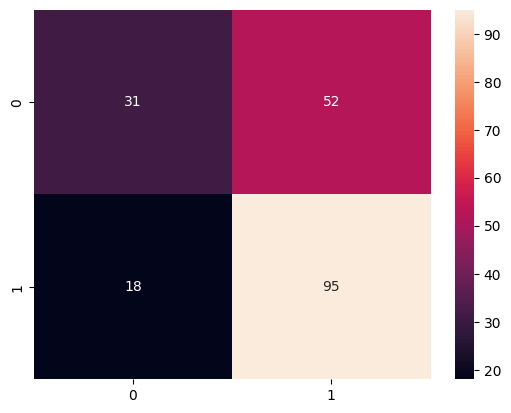

              precision    recall  f1-score   support

         0.0       0.63      0.37      0.47        83
         1.0       0.65      0.84      0.73       113

    accuracy                           0.64       196
   macro avg       0.64      0.61      0.60       196
weighted avg       0.64      0.64      0.62       196

Logistic Regression Evaluation for Merged data on Italian data trained model:


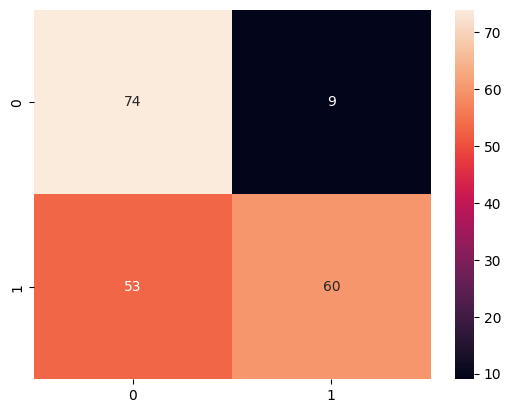

              precision    recall  f1-score   support

         0.0       0.58      0.89      0.70        83
         1.0       0.87      0.53      0.66       113

    accuracy                           0.68       196
   macro avg       0.73      0.71      0.68       196
weighted avg       0.75      0.68      0.68       196

Logistic Regression Evaluation for English data on Merged data trained model:


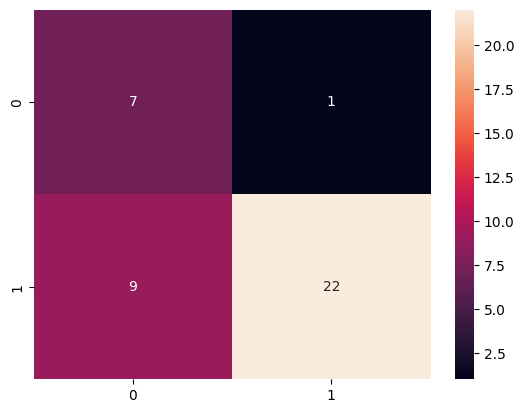

              precision    recall  f1-score   support

         0.0       0.44      0.88      0.58         8
         1.0       0.96      0.71      0.81        31

    accuracy                           0.74        39
   macro avg       0.70      0.79      0.70        39
weighted avg       0.85      0.74      0.77        39

Logistic Regression Evaluation for Italian data on Merged data trained model:


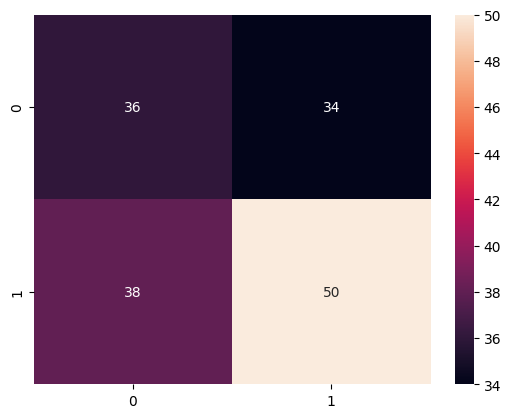

              precision    recall  f1-score   support

         0.0       0.49      0.51      0.50        70
         1.0       0.60      0.57      0.58        88

    accuracy                           0.54       158
   macro avg       0.54      0.54      0.54       158
weighted avg       0.55      0.54      0.55       158



In [25]:
from sklearn.linear_model import LogisticRegression

# Model Training for English data
lr_english = LogisticRegression()
lr_english.fit(X_train_english_smote, y_train_english_smote)

# Model Training for Italian data
lr_italian = LogisticRegression()
lr_italian.fit(X_train_italian_smote, y_train_italian_smote)

# Model Training for Merged data
lr_merged = LogisticRegression()
lr_merged.fit(X_train_merged_smote, y_train_merged_smote)

# Evaluations
y_pred_english = lr_english.predict(X_test_english)
print("Logistic Regression Evaluation for English data:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english))

y_pred_italian = lr_italian.predict(X_test_italian)
print("Logistic Regression Evaluation for Italian data:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian))

y_pred_merged = lr_merged.predict(X_test_merged)
print("Logistic Regression Evaluation for Merged data:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged))

# Evaluating Italian data on English data trained model
y_pred_italian_on_english = lr_english.predict(X_test_italian)
print("Logistic Regression Evaluation for Italian data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_english))

# Evaluating English data on Italian data trained model
y_pred_english_on_italian = lr_italian.predict(X_test_english)
print("Logistic Regression Evaluation for English data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_italian))

# Evaluating Merged data on English data trained model
y_pred_merged_on_english = lr_english.predict(X_test_merged)
print("Logistic Regression Evaluation for Merged data on English data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_english), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_english))

# Evaluating Merged data on Italian data trained model
y_pred_merged_on_italian = lr_italian.predict(X_test_merged)
print("Logistic Regression Evaluation for Merged data on Italian data trained model:")
sns.heatmap(confusion_matrix(y_test_merged, y_pred_merged_on_italian), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_merged, y_pred_merged_on_italian))

# Evaluating English data on Merged data trained model
y_pred_english_on_merged = lr_merged.predict(X_test_english)
print("Logistic Regression Evaluation for English data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_english, y_pred_english_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_english, y_pred_english_on_merged))

# Evaluating Italian data on Merged data trained model
y_pred_italian_on_merged = lr_merged.predict(X_test_italian)
print("Logistic Regression Evaluation for Italian data on Merged data trained model:")
sns.heatmap(confusion_matrix(y_test_italian, y_pred_italian_on_merged), annot=True, fmt='d')
plt.show()
print(classification_report(y_test_italian, y_pred_italian_on_merged))

# 4. Model Validation

In [26]:
from sklearn.metrics import accuracy_score

# Define a function for cross-validation and evaluation
def train_cross_validate_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Cross-validate on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Accuracy:", cv_scores.mean())
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict the labels for the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy of the predictions
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_accuracy)

In [27]:
# Define your models

rf = RandomForestClassifier()
lgb = lgb.LGBMClassifier(verbose=-1)
cat = CatBoostClassifier(verbose=False)
svm = svm.SVC()
knn = KNeighborsClassifier()
et = ExtraTreesClassifier()
log_reg = LogisticRegression()

In [28]:
models = {
    'Random Forest': rf,
    'LightGBM': lgb,
    'CatBoost': cat,
    'SVM': svm,
    'KNN': knn,
    'Extra Trees': et,
    'Logistic Regression': log_reg
}

In [29]:
# Perform cross-validation and evaluation for each model
for model_name, model in models.items():
    print(f"\n\n{model_name} Cross-Validation and Evaluation:")
    print("\nTrain and Cross-Validate on English Data, Test on English Data:")
    train_cross_validate_and_evaluate_model(model, X_train_english_smote, y_train_english_smote, X_test_english, y_test_english)
    print("\nTrain and Cross-Validate on Italian Data, Test on Italian Data:")
    train_cross_validate_and_evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_test_italian, y_test_italian)
    print("\nTrain and Cross-Validate on Merged Data, Test on Merged Data:")
    train_cross_validate_and_evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_test_merged, y_test_merged)
    print("\nTrain and Cross-Validate on English Data, Test on Italian Data:")
    train_cross_validate_and_evaluate_model(model, X_train_english_smote, y_train_english_smote, X_train_italian_smote, y_train_italian_smote)
    print("\nTrain and Cross-Validate on Italian Data, Test on English Data:")
    train_cross_validate_and_evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_train_english_smote, y_train_english_smote)
    print("\nTrain and Cross-Validate on English Data, Test on Merged Data:")
    train_cross_validate_and_evaluate_model(model, X_train_english_smote, y_train_english_smote, X_train_merged_smote, y_train_merged_smote)
    print("\nTrain and Cross-Validate on Italian Data, Test on Merged Data:")
    train_cross_validate_and_evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_train_merged_smote, y_train_merged_smote)
    print("\nTrain and Cross-Validate on Merged Data, Test on English Data:")
    train_cross_validate_and_evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_train_english_smote, y_train_english_smote)
    print("\nTrain and Cross-Validate on Merged Data, Test on Italian Data:")
    train_cross_validate_and_evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_train_italian_smote, y_train_italian_smote)



Random Forest Cross-Validation and Evaluation:

Train and Cross-Validate on English Data, Test on English Data:


Cross-Validation Scores: [0.95652174 0.95652174 0.91304348 0.91304348 1.         1.
 0.90909091 0.95454545 0.95454545 1.        ]
Mean Cross-Validation Accuracy: 0.9557312252964427
Test Accuracy: 0.9487179487179487

Train and Cross-Validate on Italian Data, Test on Italian Data:
Cross-Validation Scores: [0.77142857 0.91428571 0.77142857 0.84285714 0.91428571 0.85714286
 0.94285714 0.82857143 0.92753623 0.91304348]
Mean Cross-Validation Accuracy: 0.8683436853002069
Test Accuracy: 0.8227848101265823

Train and Cross-Validate on Merged Data, Test on Merged Data:
Cross-Validation Scores: [0.89361702 0.86170213 0.89361702 0.89361702 0.88297872 0.87234043
 0.86021505 0.90322581 0.93548387 0.95698925]
Mean Cross-Validation Accuracy: 0.8953786318920155
Test Accuracy: 0.8469387755102041

Train and Cross-Validate on English Data, Test on Italian Data:
Cross-Validation Scores: [0.95652174 0.95652174 0.91304348 0.91304348 1.         1.
 0.90909091 0.95454545 1.         1.        ]
Mean Cross-Valid

# 5. Ensembling Methods


## Stacking

In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

# Define the base models
base_models = list(models.items())

# Initialize the Stacking Classifier with the base models and a final estimator
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier())

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=model.classes_)
    confusion_matrix_display.plot()
    plt.show()    

    # Print metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")



Stacking Classifier Evaluation:

Train on English Data, Test on English Data:


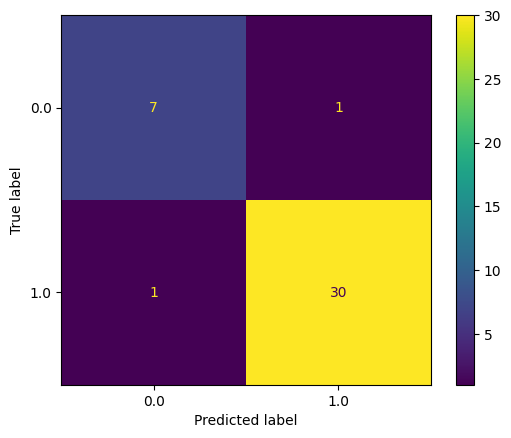

Accuracy: 0.9487179487179487
Precision: 0.9487179487179487
Recall: 0.9487179487179487
F1 Score: 0.9487179487179487

Train on Italian Data, Test on Italian Data:


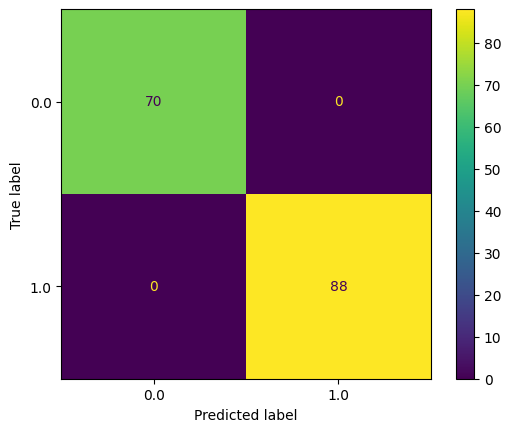

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Train on Merged Data, Test on Merged Data:


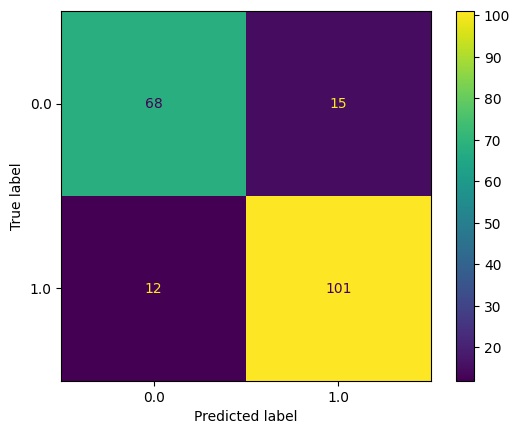

Accuracy: 0.8622448979591837
Precision: 0.8619282195636875
Recall: 0.8622448979591837
F1 Score: 0.8618795389669786

Train on English Data, Test on Italian Data:


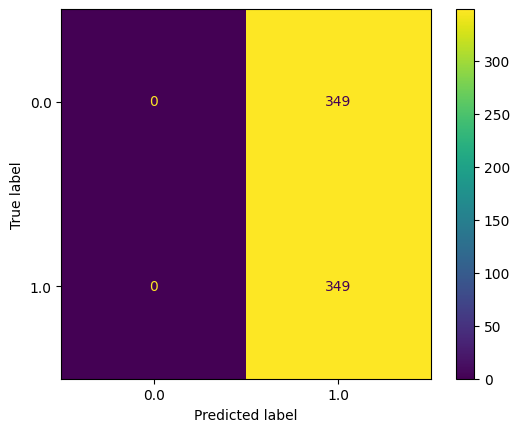

Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.3333333333333333

Train on Italian Data, Test on English Data:


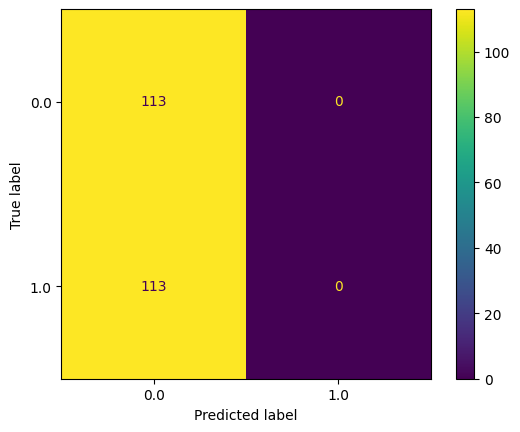

Accuracy: 0.5
Precision: 0.25
Recall: 0.5
F1 Score: 0.3333333333333333

Train on English Data, Test on Merged Data:


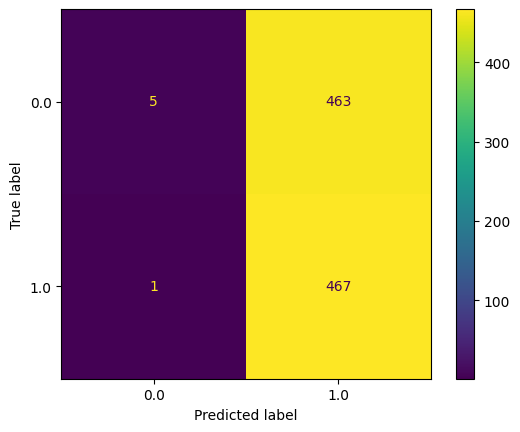

Accuracy: 0.5042735042735043
Precision: 0.667741935483871
Recall: 0.5042735042735043
F1 Score: 0.34459716412234476

Train on Italian Data, Test on Merged Data:


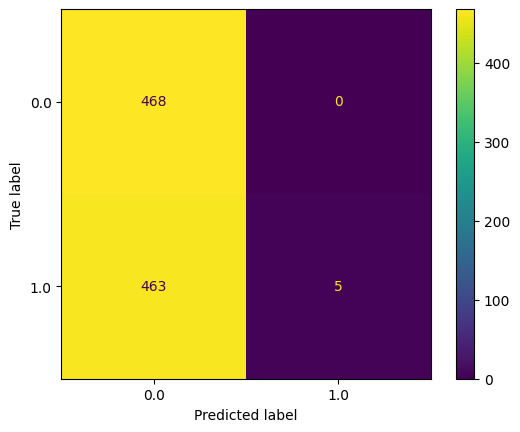

Accuracy: 0.5053418803418803
Precision: 0.751342642320086
Recall: 0.5053418803418803
F1 Score: 0.3450954849960784

Train on Merged Data, Test on English Data:


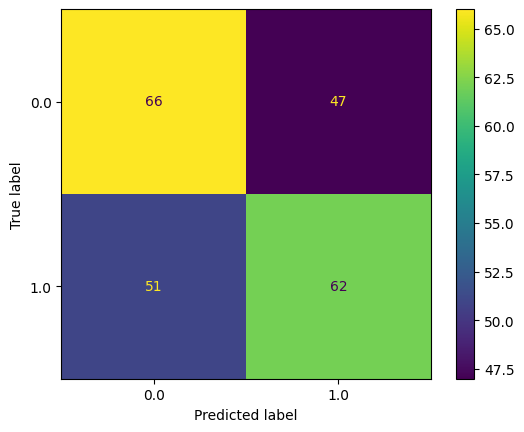

Accuracy: 0.5663716814159292
Precision: 0.5664549517760528
Recall: 0.5663716814159292
F1 Score: 0.5662358010184098

Train on Merged Data, Test on Italian Data:


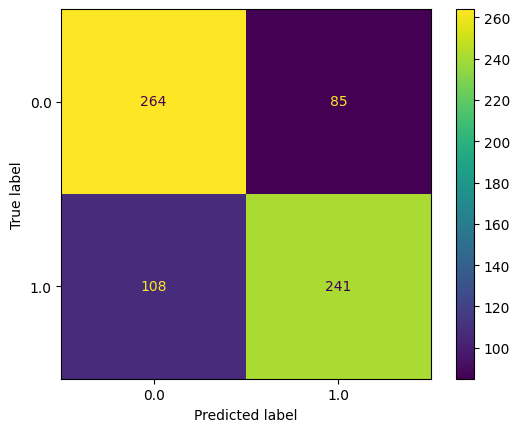

Accuracy: 0.7234957020057307
Precision: 0.7244706115179101
Recall: 0.7234957020057307
F1 Score: 0.7231951507679663


In [37]:
# Perform evaluation for each model
for model_name, model in {'Stacking Classifier': stacking_clf}.items():
    print(f"\n\n{model_name} Evaluation:")
    print("\nTrain on English Data, Test on English Data:")
    evaluate_model(model, X_train_english_smote, y_train_english_smote, X_test_english, y_test_english)
    print("\nTrain on Italian Data, Test on Italian Data:")
    evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_test_italian, y_test_italian)
    print("\nTrain on Merged Data, Test on Merged Data:")
    evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_test_merged, y_test_merged)
    print("\nTrain on English Data, Test on Italian Data:")
    evaluate_model(model, X_train_english_smote, y_train_english_smote, X_train_italian_smote, y_train_italian_smote)
    print("\nTrain on Italian Data, Test on English Data:")
    evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_train_english_smote, y_train_english_smote)
    print("\nTrain on English Data, Test on Merged Data:")
    evaluate_model(model, X_train_english_smote, y_train_english_smote, X_train_merged_smote, y_train_merged_smote)
    print("\nTrain on Italian Data, Test on Merged Data:")
    evaluate_model(model, X_train_italian_smote, y_train_italian_smote, X_train_merged_smote, y_train_merged_smote)
    print("\nTrain on Merged Data, Test on English Data:")
    evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_train_english_smote, y_train_english_smote)
    print("\nTrain on Merged Data, Test on Italian Data:")
    evaluate_model(model, X_train_merged_smote, y_train_merged_smote, X_train_italian_smote, y_train_italian_smote)

## ROC Curve

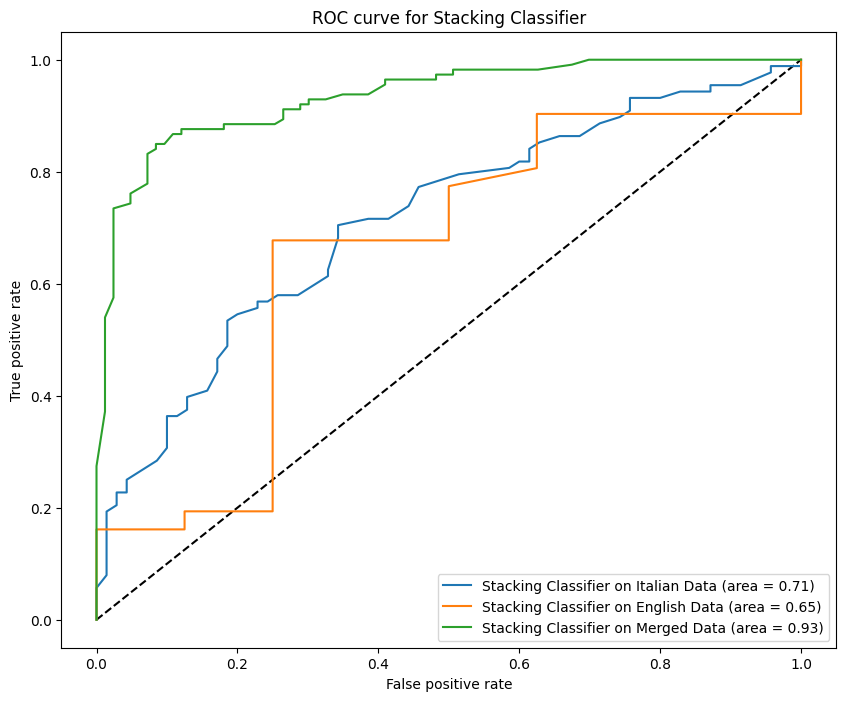

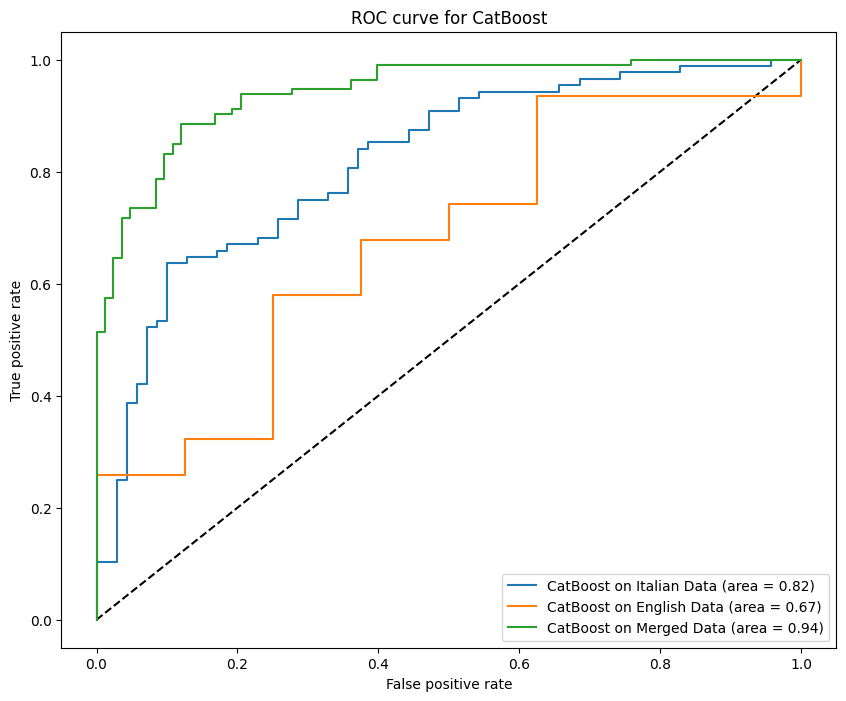

[LightGBM] [Info] Number of positive: 468, number of negative: 468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5024
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


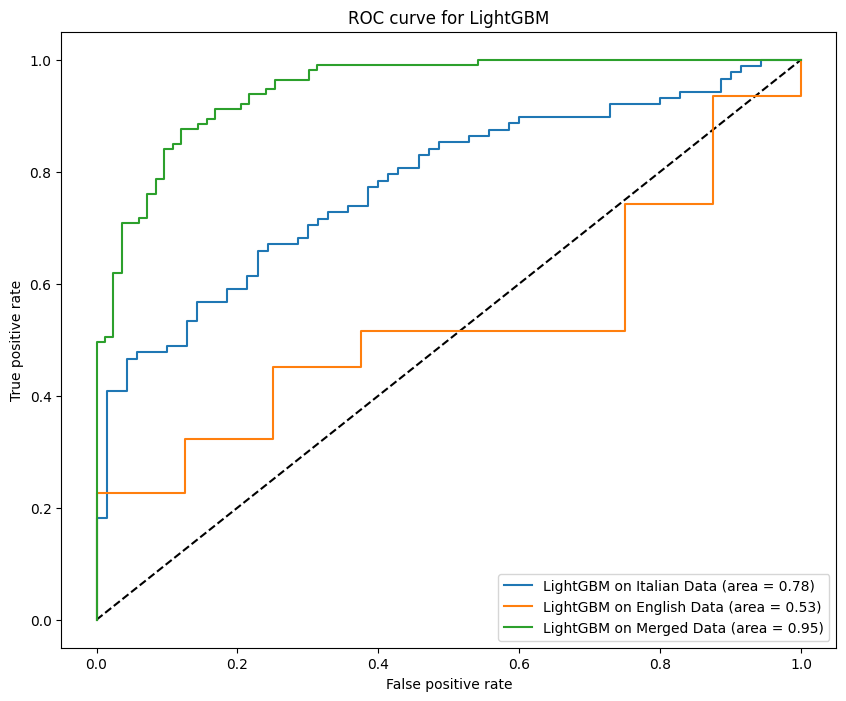

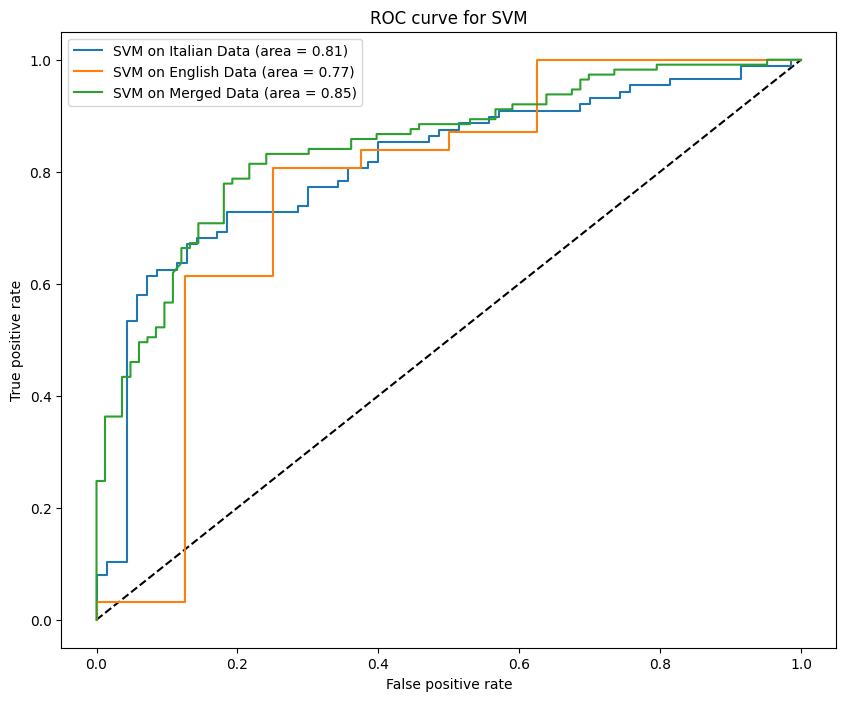

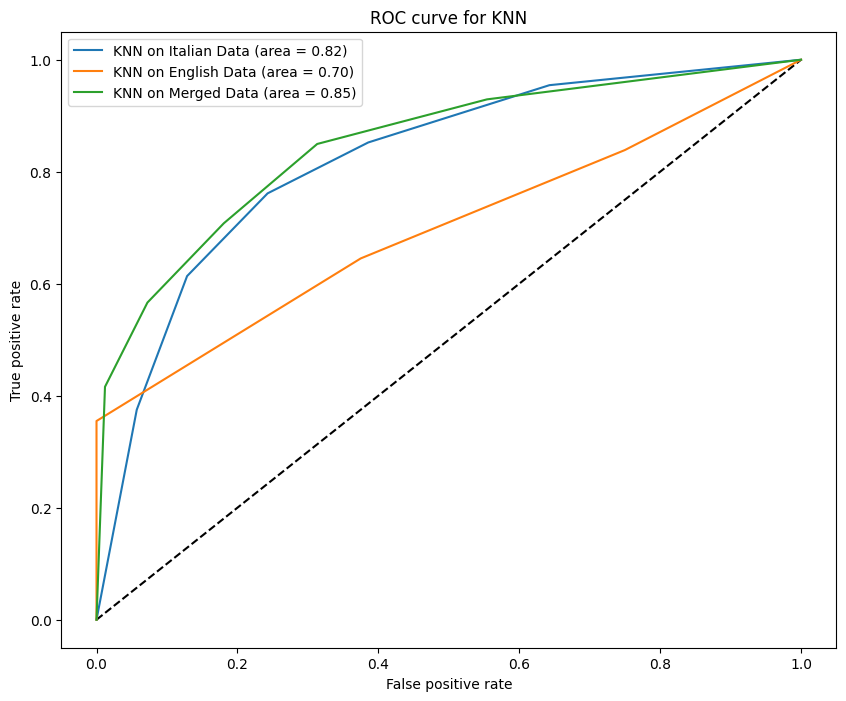

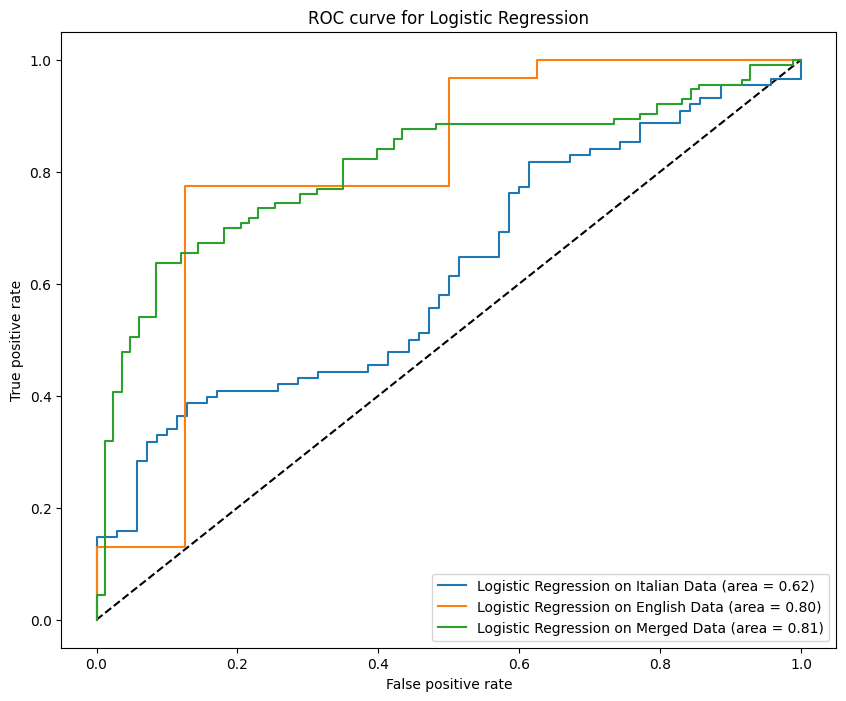

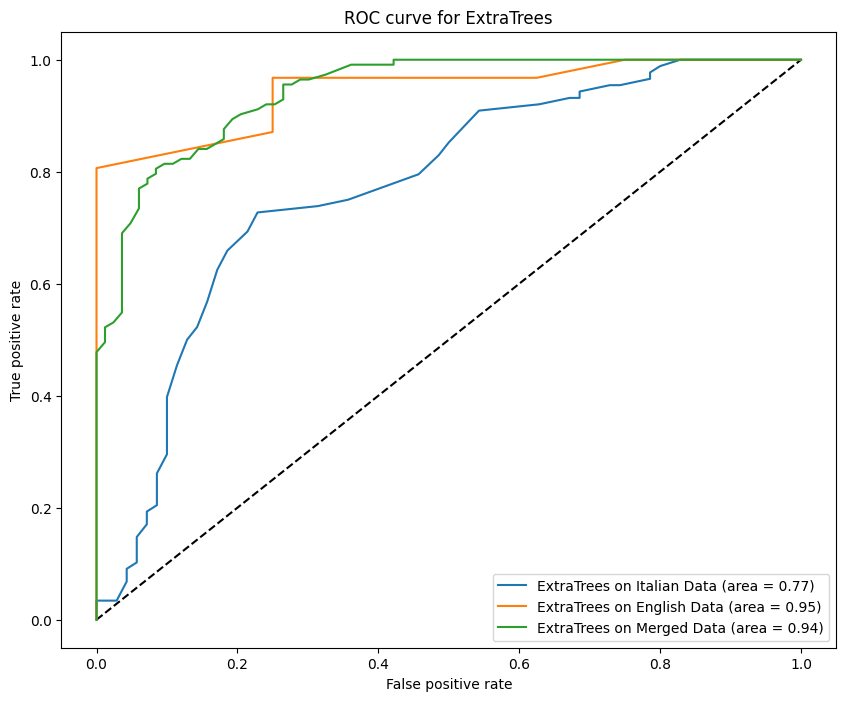

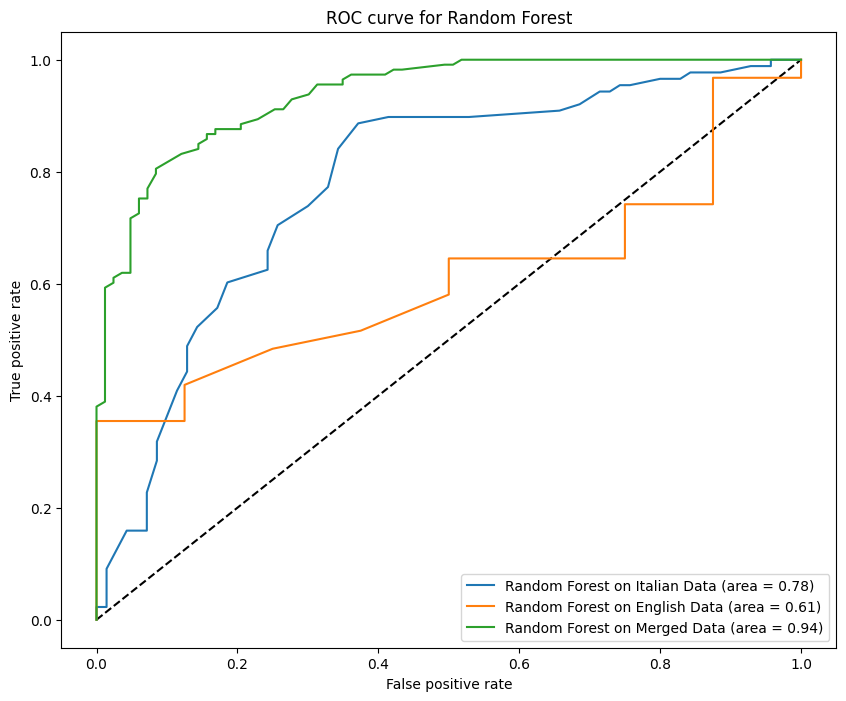

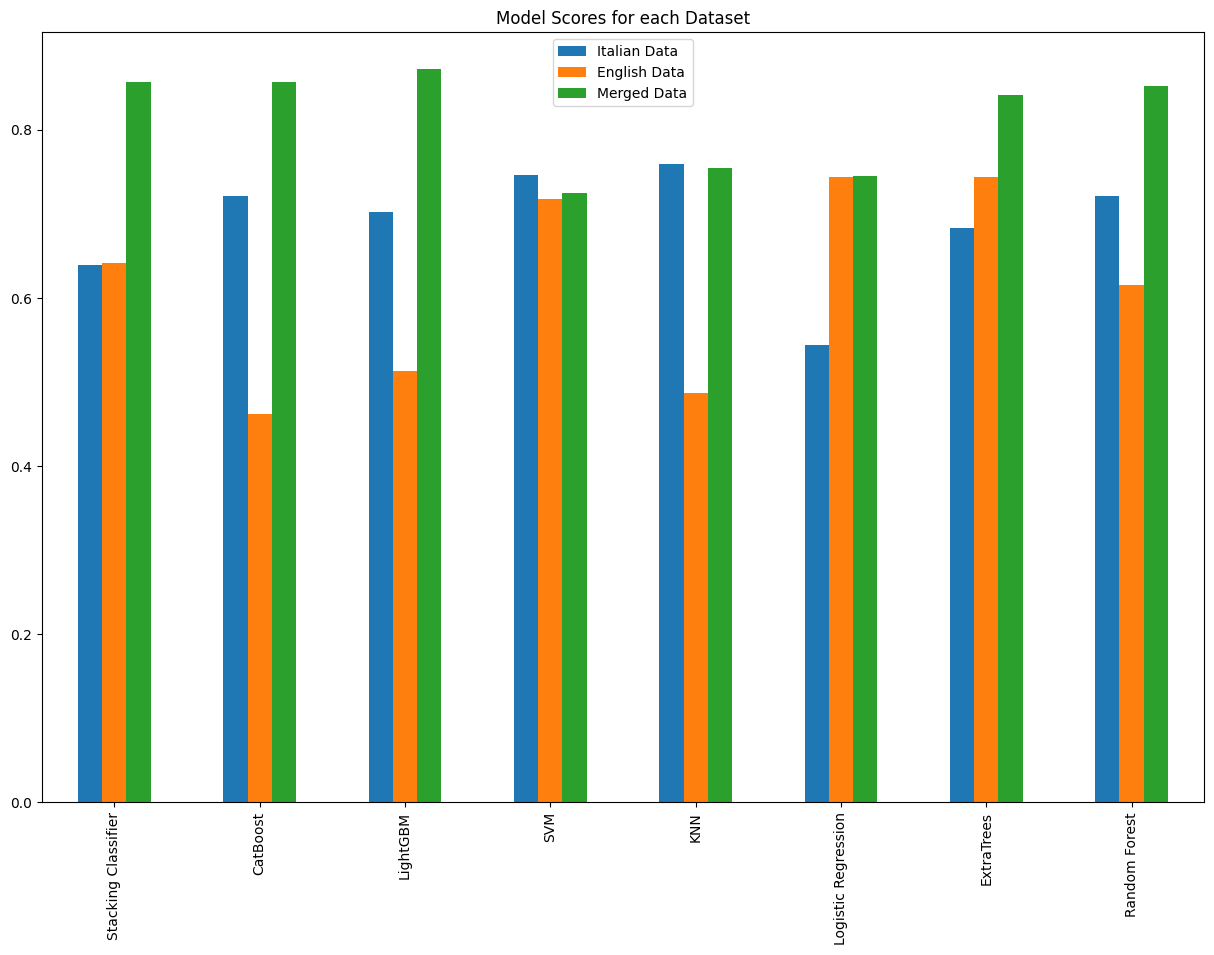

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Define your models
models = {
    'Stacking Classifier': stacking_clf,
    'CatBoost': CatBoostClassifier(silent=True),
    'LightGBM': LGBMClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'ExtraTrees': ExtraTreesClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Define your datasets
datasets = {
    "Italian Data": (X_test_italian, y_test_italian),
    "English Data": (X_test_english, y_test_english),
    "Merged Data": (X_test_merged, y_test_merged)
}

# Train on merged data
X_train, y_train = X_train_merged_smote, y_train_merged_smote

# Initialize an empty DataFrame to hold feature importances
feature_importances = pd.DataFrame(index=X_train.columns)  # assuming X_train is a DataFrame

# Initialize an empty DataFrame to hold model scores
model_scores = pd.DataFrame()

# For each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Check if the model has a feature_importances_ attribute
    if hasattr(model, 'feature_importances_'):
        # If yes, add the feature importances to the DataFrame
        feature_importances[model_name] = model.feature_importances_

    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    # For each dataset
    for data_name, (X_test, y_test) in datasets.items():
        # Calculate probabilities and ROC curve
        probabilities = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} on {data_name} (area = {roc_auc:.2f})')

        # Calculate the score and add it to the DataFrame
        score = model.score(X_test, y_test)
        model_scores.loc[model_name, data_name] = score

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model_name}')
    plt.legend(loc='best')
    plt.show()



# Plot model scores
model_scores.plot(kind='bar', figsize=(15, 10))
plt.title('Model Scores for each Dataset')
plt.show()